In [ ]:
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'
os.environ["WANDB_API_KEY"] = "6f810b088fcc6b9eaaa56c1e52cfd37836606240"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q tensorflow==2.6.2
!pip install -q tensorflow-recommenders==0.6.0
!pip install -q scann==1.2.3
!pip install -q tensorflow-datasets
!pip install -q tensorflow-addons
!pip install -q tensorflow-hub
!pip install -q keras-tuner
!pip install -q statsmodels
!pip install -q optuna
!pip install -q wandb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 형태소분석기 관련 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip install JPype1
!pip install rhinoMorph

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-driver

In [ ]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [ ]:
import sys
# import wandb
# from wandb.keras import WandbCallback
# from optuna.integration.wandb import WeightsAndBiasesCallback as optuna_wnbcallback
# from optuna import pruners
import shutil
from glob import glob
from IPython.display import Image, display
import gc
import wandb

from multiprocessing import cpu_count
import copy
import pickle
import warnings
from datetime import datetime, timedelta
from time import time, sleep, mktime
from matplotlib import font_manager as fm, rc, rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import random as rnd
import psutil

import numpy as np
from numpy import array, nan, random as np_rnd, where as which
import pandas as pd
from pandas import DataFrame as dataframe, Series as series, isna, read_csv
from pandas.tseries.offsets import DateOffset

from sklearn.model_selection import train_test_split as tts, GridSearchCV as GridTuner, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
from sklearn import metrics
# from optuna import Trial, create_study

# ===== tensorflow =====
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import metrics as tf_metrics
from tensorflow.keras import callbacks as tf_callbacks
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow_recommenders.tasks import base
from keras.utils.layer_utils import count_params

import keras_tuner as kt
from keras_tuner import HyperModel
import tensorflow_hub as tf_hub

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import scann

import rhinoMorph
from kobert_tokenizer import KoBERTTokenizer
import sentencepiece
from transformers import BertModel
import torch
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings(action='ignore')
rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 200)

# GPU check
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

Found GPU at: /device:GPU:0


# Utility Funtions

In [ ]:
# ===== utility functions =====
# label encoding for categorical column with excepting na value
def seed_everything(seed=42):
    # python-self
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random module
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # tf random
    tf.random.set_seed(seed)
    # RAPIDS random
    try:
        cp.random.seed(seed)
    except:
        pass
def easyIO(x=None, path=None, op="r", keras_inspection=False):
    tmp = None
    if op == "r":
        with open(path, "rb") as f:
            tmp = pickle.load(f)
        return tmp
    elif op == "w":
        print(x)
        tmp = x
        if keras_inspection:
            tmp = {}
            if type(x) is dict:
                for k in x.keys():
                    if "MLP" in k:
                        tmp[k] = {}
                        for model_comps in x[k].keys():
                            if model_comps != "model":
                                tmp[k][model_comps] = copy.deepcopy(x[k][model_comps])
                        print(F"INFO : {k} model is removed (keras)")
                    else:
                        tmp[k] = x[k]
        if input("Write [y / n]: ") == "y":
            with open(path, "wb") as f:
                pickle.dump(tmp, f)
            print("operation success")
        else:
            print("operation fail")
    else:
        print("Unknown operation type")
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]
def orderElems(for_order, using_ref):
    return [i for i in using_ref if i in for_order]
# concatenate by row
def cbr(df1, df2):
    if type(df1) == series:
        tmp_concat = series(pd.concat([dataframe(df1), dataframe(df2)], axis=0, ignore_index=True).iloc[:,0])
        tmp_concat.reset_index(drop=True, inplace=True)
    elif type(df1) == dataframe:
        tmp_concat = pd.concat([df1, df2], axis=0, ignore_index=True)
        tmp_concat.reset_index(drop=True, inplace=True)
    elif type(df1) == np.ndarray:
        tmp_concat = np.concatenate([df1, df2], axis=0)
    else:
        print("Unknown Type: return 1st argument")
        tmp_concat = df1
    return tmp_concat
def change_width(ax, new_value):
    for patch in ax.patches :
        current_width = patch.get_width()
        adj_value = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + adj_value * .5)
def week_of_month(date):
    month = date.month
    week = 0
    while date.month == month:
        week += 1
        date -= timedelta(days=7)
    return week
def getSeason(date):
    month = date.month
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return "Winter"
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
def softmax(x):
    max = np.max(x, axis=1, keepdims=True)  # returns max of each row and keeps same dims
    e_x = np.exp(x - max)  # subtracts each row with its max value
    sum = np.sum(e_x, axis=1, keepdims=True)  # returns sum of each row and keeps same dims
    f_x = e_x / sum
    return f_x
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def dispPerformance(result_dic):
    perf_table = dataframe()
    index_names = []
    for k, v in result_dic.items():
        index_names.append(k)
        perf_table = pd.concat([perf_table, series(v["performance"]).to_frame().T], ignore_index=True, axis=0)
    perf_table.index = index_names
    perf_table.sort_values(perf_table.columns[0], inplace=True)
    print(perf_table)
    return perf_table
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)
def xgb_custom_lossfunction(alpha = 1):
    def support_under_mse(label, pred):
        # grad : 1차 미분
        # hess : 2차 미분
        residual = (label - pred).astype("float")
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * alpha, 2.0)
        return grad, hess
    return support_under_mse
def pd_flatten(df):
    df = df.unstack()
    df.index = [str(i) + "_" + str(j) for i, j in df.index]
    return df
def tf_loss_rmse(y_true, y_pred, sample_weight=False):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred) ** 2)) if not sample_weight else tf.sqrt(tf.reduce_mean(((y_true - y_pred) ** 2) * sample_weight))
def text_extractor(string, lang="eng", spacing=True):
    # # 괄호를 포함한 괄호 안 문자 제거 정규식
    # re.sub(r'\([^)]*\)', '', remove_text)
    # # <>를 포함한 <> 안 문자 제거 정규식
    # re.sub(r'\<[^)]*\>', '', remove_text)
    if lang == "eng":
        text_finder = re.compile('[^ A-Za-z]') if spacing else re.compile('[^A-Za-z]')
    elif lang == "kor":
        text_finder = re.compile('[^ ㄱ-ㅣ가-힣+]') if spacing else re.compile('[^ㄱ-ㅣ가-힣+]')
    # default : kor + eng
    else:
        text_finder = re.compile('[^ A-Za-zㄱ-ㅣ가-힣+]') if spacing else re.compile('[^A-Za-zㄱ-ㅣ가-힣+]')
    return text_finder.sub('', string)
class MyLabelEncoder:
    def __init__(self, preset={}):
        # dic_cat format -> {"col_name": {"value": replace}}
        self.dic_cat = preset
    def fit_transform(self, data_x, col_names):
        tmp_x = copy.deepcopy(data_x)
        for i in col_names:
            # if key is not in dic, update dic
            if i not in self.dic_cat.keys():
                tmp_dic = dict.fromkeys(sorted(set(tmp_x[i]).difference([nan])))
                label_cnt = 0
                for j in tmp_dic.keys():
                    tmp_dic[j] = label_cnt
                    label_cnt += 1
                self.dic_cat[i] = tmp_dic
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def transform(self, data_x):
        tmp_x = copy.deepcopy(data_x)
        for i in self.dic_cat.keys():
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def clear(self):
        self.dic_cat = {}
class MyOneHotEncoder:
    def __init__(self, label_preset={}):
        self.dic_cat = {}
        self.label_preset = label_preset
    def fit_transform(self, data_x, col_names):
        tmp_x = dataframe()
        for i in data_x:
            if i not in col_names:
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                self.dic_cat[i] = OneHotEncoder(sparse=False, handle_unknown="ignore")
                conv = self.dic_cat[i].fit_transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j:
                                col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def transform(self, data_x):
        tmp_x = dataframe()
        for i in data_x:
            if not i in list(self.dic_cat.keys()):
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                conv = self.dic_cat[i].transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j: col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def clear(self):
        self.dic_cat = {}
        self.label_preset = {}
class MyKNNImputer:
    def __init__(self, k=5):
        self.imputer = KNNImputer(n_neighbors=k)
        self.dic_cat = {}
    def fit_transform(self, x, cat_vars=None):
        if cat_vars is None:
            x_imp = dataframe(self.imputer.fit_transform(x), columns=x.columns)
        else:
            naIdx = dict.fromkeys(cat_vars)
            for i in cat_vars:
                self.dic_cat[i] = diff(list(sorted(set(x[i]))), [nan])
                naIdx[i] = list(which(array(x[i].isna())))
            x_imp = dataframe(self.imputer.fit_transform(x), columns=x.columns)

            # if imputed categorical value are not in the range, adjust the value
            for i in cat_vars:
                x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
                for j in naIdx[i]:
                    if x_imp[i][j] not in self.dic_cat[i]:
                        if x_imp[i][j] < self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][0]
                        elif x_imp[i][j] > self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][len(self.dic_cat[i]) - 1]
        return x_imp
    def transform(self, x):
        if len(self.dic_cat.keys()) == 0:
            x_imp = dataframe(self.imputer.transform(x), columns=x.columns)
        else:
            naIdx = dict.fromkeys(self.dic_cat.keys())
            for i in self.dic_cat.keys():
                naIdx[i] = list(which(array(x[i].isna())))
            x_imp = dataframe(self.imputer.transform(x), columns=x.columns)

            # if imputed categorical value are not in the range, adjust the value
            for i in self.dic_cat.keys():
                x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
                for j in naIdx[i]:
                    if x_imp[i][j] not in self.dic_cat[i]:
                        if x_imp[i][j] < self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][0]
                        elif x_imp[i][j] > self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][len(self.dic_cat[i]) - 1]
        return x_imp
    def clear(self):
        self.imputer = None
        self.dic_cat = {}

def memory_usage(message='debug'):
    # current process RAM usage
    p = psutil.Process()
    rss = p.memory_info().rss / 2 ** 20 # Bytes to MB
    print(f"[{message}] memory usage: {rss: 10.3f} MB")
    return rss

# Preprocessing & Feature Engineering

In [ ]:
# 데이터 로딩
def read_data(filename, encoding='utf8'):
  with open(filename, 'r', encoding=encoding) as f:
    data = [line.split('|') for line in f.read().splitlines()]
  return data

def write_data(data, filename, encoding='utf8'):
  with open(filename, 'w', encoding=encoding) as f:
    f.write(data)

folder_path = '/content/drive/MyDrive/Colab Notebooks/projects/other_competition/통계청_산업분류경진대회_NLP/'

# header info : AI_id|digit_1|digit_2|digit_3|text_obj|text_mthd|text_deal
full_x = read_data('/content/drive/MyDrive/Colab Notebooks/projects/other_competition/통계청_산업분류경진대회_NLP/1. 실습용자료.txt', encoding='cp949')[1:]
test_x = read_data('/content/drive/MyDrive/Colab Notebooks/projects/other_competition/통계청_산업분류경진대회_NLP/2. 모델개발용자료.txt', encoding='cp949')[1:]

In [ ]:
full_x = dataframe(full_x, columns=["AI_id", "digit_1", "digit_2", "digit_3", "text_obj", "text_mthd", "text_deal"])
test_x = dataframe(test_x, columns=["AI_id", "digit_1", "digit_2", "digit_3", "text_obj", "text_mthd", "text_deal"])

In [ ]:
full_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   AI_id      1000000 non-null  object
 1   digit_1    1000000 non-null  object
 2   digit_2    1000000 non-null  object
 3   digit_3    1000000 non-null  object
 4   text_obj   1000000 non-null  object
 5   text_mthd  1000000 non-null  object
 6   text_deal  1000000 non-null  object
dtypes: object(7)
memory usage: 53.4+ MB


In [ ]:
full_x.head()

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal
0,id_0000001,S,95,952,카센터에서,자동차부분정비,타이어오일교환
1,id_0000002,G,47,472,상점내에서,일반인을 대상으로,채소.과일판매
2,id_0000003,G,46,467,절단하여사업체에도매,공업용고무를가지고,합성고무도매
3,id_0000004,G,47,475,영업점에서,일반소비자에게,열쇠잠금장치
4,id_0000005,Q,87,872,어린이집,보호자의 위탁을 받아,취학전아동보육


In [ ]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   AI_id      100000 non-null  object
 1   digit_1    100000 non-null  object
 2   digit_2    100000 non-null  object
 3   digit_3    100000 non-null  object
 4   text_obj   100000 non-null  object
 5   text_mthd  100000 non-null  object
 6   text_deal  100000 non-null  object
dtypes: object(7)
memory usage: 5.3+ MB


In [ ]:
test_x.head()

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal
0,id_000001,,,,치킨전문점에서,고객의주문에의해,치킨판매
1,id_000002,,,,산업공구,다른 소매업자에게,철물 수공구
2,id_000003,,,,절에서,신도을 대상으로,불교단체운영
3,id_000004,,,,영업장에서,고객요구로,자동차튜닝
4,id_000005,,,,실내포장마차에서,접객시설을 갖추고,"소주,맥주제공"


In [ ]:
text_vars = ["text_obj", "text_mthd", "text_deal"]

In [ ]:
# full_x["sentence"] = full_x["text_obj"] + " " + full_x["text_mthd"] + " " + full_x["text_deal"]
# test_x["sentence"] = test_x["text_obj"] + " " + test_x["text_mthd"] + " " + test_x["text_deal"]

In [ ]:
# full_x["sentence"] = full_x["sentence"].apply(lambda x: text_extractor(x, "both", True))
# test_x["sentence"] = test_x["sentence"].apply(lambda x: text_extractor(x, "both", True))

In [ ]:
# for i in text_vars:
#     full_x[i] = full_x[i].apply(lambda x: text_extractor(x, "both", True))
#     test_x[i] = test_x[i].apply(lambda x: text_extractor(x, "both", True))

In [ ]:
full_x.drop(["AI_id"], axis=1, inplace=True)
test_x.drop(["AI_id"], axis=1, inplace=True)

In [ ]:
# rn = rhinoMorph.startRhino()

# for k in text_vars:
#     if os.path.exists(folder_path + "datasets/" + k + "_train_prep.txt"):
#         os.remove(folder_path + "datasets/" + k + "_train_prep.txt")
#     with open(folder_path + "datasets/" + k + "_train_prep.txt", 'a', encoding="cp949") as f:
#         for i in full_x[k]:
#             f.write(" ".join([j.lower() for j in rhinoMorph.onlyMorph_list(rn, i) if len(j) > 1]) + "\n")

#     if os.path.exists(folder_path + "datasets/" + k + "_test_prep.txt"):
#         os.remove(folder_path + "datasets/" + k + "_test_prep.txt")
#     with open(folder_path + "datasets/" + k + "_test_prep.txt", 'a', encoding="cp949") as f:
#         for i in test_x[k]:
#             f.write(" ".join([j.lower() for j in rhinoMorph.onlyMorph_list(rn, i) if len(j) > 1]) + "\n")

In [ ]:
# for label encoding the each features
for k in text_vars:
    with open(folder_path + "datasets/" + k + "_train_prep.txt", 'r', encoding="cp949") as f:
        full_x[k] = [i.strip() for i in f.readlines()]
    with open(folder_path + "datasets/" + k + "_test_prep.txt", 'r', encoding="cp949") as f:
        test_x[k] = [i.strip() for i in f.readlines()]

In [ ]:
# for tf-idf
with open(folder_path + "train_prep.txt", 'r', encoding="cp949") as f:
    full_x["sentence"] = [i.strip() for i in f.readlines()]
with open(folder_path + "test_prep.txt", 'r', encoding="cp949") as f:
    test_x["sentence"] = [i.strip() for i in f.readlines()]

In [ ]:
full_x.head()

,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,sentence
0,S,95,952,카센터 에서,자동차 부분 정비,타이어 오일 교환,카센터 에서 자동차 부분 정비 타이어 오일 교환
1,G,47,472,상점 에서,일반인 대상 으로,채소 과일 판매,상점 에서 일반인 대상 으로 채소 과일 판매
2,G,46,467,절단 사업체 에도,공업 용고무를 가지,합성고무 도매,절단 사업체 에도 공업 용고무를 가지 합성고무 도매
3,G,47,475,영업점 에서,일반 소비자 에게,열쇠 잠금장치,영업점 에서 일반 소비자 에게 열쇠 잠금장치
4,Q,87,872,어린이집,보호자 위탁,취학 아동 보육,어린이집 보호자 위탁 취학 아동 보육


In [ ]:
test_x.head()

,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,sentence
0,,,,치킨 전문점 에서,고객 주문,치킨 판매,치킨 전문점 에서 고객 주문 치킨 판매
1,,,,산업 공구,다른 소매업자 에게,철물 수공,산업 공구 다른 소매업자 에게 철물 수공
2,,,,에서,신도 대상 으로,불교 단체 운영,에서 신도 대상 으로 불교 단체 운영
3,,,,영업장 에서,고객 요구,자동차 튜닝,영업장 에서 고객 요구 자동차 튜닝
4,,,,실내 포장마차 에서,접객 시설 갖추,소주 맥주 제공,실내 포장마차 에서 접객 시설 갖추 소주 맥주 제공


In [ ]:
target_encoder = MyLabelEncoder()
full_y = full_x[["digit_1", "digit_2", "digit_3"]].copy()
full_y = target_encoder.fit_transform(full_y, ["digit_1", "digit_2", "digit_3"]).astype("int32")

In [ ]:
for i in target_encoder.dic_cat.keys():
    print(len(target_encoder.dic_cat[i].keys()))

19
74
225


In [ ]:
full_x.drop(["digit_1", "digit_2", "digit_3"], axis=1, inplace=True)
test_x.drop(["digit_1", "digit_2", "digit_3"], axis=1, inplace=True)

In [ ]:
full_x.head()

,text_obj,text_mthd,text_deal,sentence
0,카센터 에서,자동차 부분 정비,타이어 오일 교환,카센터 에서 자동차 부분 정비 타이어 오일 교환
1,상점 에서,일반인 대상 으로,채소 과일 판매,상점 에서 일반인 대상 으로 채소 과일 판매
2,절단 사업체 에도,공업 용고무를 가지,합성고무 도매,절단 사업체 에도 공업 용고무를 가지 합성고무 도매
3,영업점 에서,일반 소비자 에게,열쇠 잠금장치,영업점 에서 일반 소비자 에게 열쇠 잠금장치
4,어린이집,보호자 위탁,취학 아동 보육,어린이집 보호자 위탁 취학 아동 보육


In [ ]:
full_y.head()

,digit_1,digit_2,digit_3
0,18,72,221
1,6,37,120
2,6,36,117
3,6,37,123
4,16,68,212


In [ ]:
test_x.head()

,text_obj,text_mthd,text_deal,sentence
0,치킨 전문점 에서,고객 주문,치킨 판매,치킨 전문점 에서 고객 주문 치킨 판매
1,산업 공구,다른 소매업자 에게,철물 수공,산업 공구 다른 소매업자 에게 철물 수공
2,에서,신도 대상 으로,불교 단체 운영,에서 신도 대상 으로 불교 단체 운영
3,영업장 에서,고객 요구,자동차 튜닝,영업장 에서 고객 요구 자동차 튜닝
4,실내 포장마차 에서,접객 시설 갖추,소주 맥주 제공,실내 포장마차 에서 접객 시설 갖추 소주 맥주 제공


In [ ]:
def create_model_vectorization(input_shape, max_vocab, adapt_corpus, output_mode="int", output_sequence_length=None):
    vectorizer = layers.TextVectorization(
            max_tokens=max_vocab,
            output_mode=output_mode,
            output_sequence_length=output_sequence_length,
            standardize=None,
            name="tv"
    )
    vectorizer.adapt(adapt_corpus)
    model = Sequential([
        layers.InputLayer(input_shape=input_shape, dtype=tf.string),
        vectorizer
    ])
    return model

In [ ]:
# for i in text_vars:
#     with tf.device('/CPU:0'):
#         max_vocab = 2048
#         doc_vectorize = create_model_vectorization(1, max_vocab, full_x[i].to_numpy(), output_mode="int", output_sequence_length=None)
#         print(doc_vectorize.get_layer("tv").vocabulary_size())
#         doc_vectorize.compile()
#         doc_vectorize.save(os.path.join(folder_path, "models/vectorizer_int_" + i))
# doc_vectorize = load_model(os.path.join(folder_path, "models/doc_vectorizer_vocab4096"))
# print(doc_vectorize.get_layer("tv").vocabulary_size())

In [ ]:
# with tf.device('/CPU:0'):
#     full_doc_embed = doc_vectorize(full_x["sentence"].to_numpy()).numpy()
#     test_doc_embed = doc_vectorize(test_x["sentence"].to_numpy()).numpy()

In [ ]:
# full_doc_embed = pad_sequences(full_doc_embed, padding='pre')
# test_doc_embed = pad_sequences(test_doc_embed, padding='pre')

In [ ]:
# text vectorizer for tf-idf
vectorizer_tfidf = load_model(os.path.join(folder_path, "models/doc_vectorizer_vocab4096"))

# NN models

In [ ]:
dropoutRate = 0.25
embed_len = 8

In [ ]:
def create_dataset(x, y, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(int(batch_size * 2), reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2)
    return dataset

# Model - seperated label encoding

In [ ]:
# def create_model_digit1():

#     model_input = []
#     raw_embed = []
#     dcn_list = []
#     for i in text_vars:
#         model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
#         raw_embed.append(layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1]))
#         x = layers.Dropout(dropoutRate)(raw_embed[-1])
#         x = layers.Dense(16, activation="relu")(x)
#         x = layers.Dropout(dropoutRate)(x)
#         x = layers.Dense(4)(x)
#         dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

#         # model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
#         # x = layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1])
#         # dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

#     x = layers.Concatenate(axis=1)(dcn_list)
#     dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
#     dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))

#     x = layers.Concatenate()([
#         layers.Flatten()(x),
#         layers.Flatten()(dcn1),
#         layers.Flatten()(dcn2),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2]))
#     ])
#     # input_dense1 = layers.Dense(256, activation="relu", kernel_regularizer="l1")(x)
#     input_dense1 = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense1)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense2 = layers.Concatenate()([input_dense1, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense2)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense3 = layers.Concatenate()([input_dense2, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense3)
#     x = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish"),
#         name="transfer"
#     )(x)

#     classifier_digit1 = layers.Dense(len(target_encoder.dic_cat["digit_1"].keys()), activation="softmax")(x)
#     # classifier_digit2 = layers.Dense(len(target_encoder.dic_cat["digit_2"].keys()), activation="softmax")(x)
#     # classifier_digit3 = layers.Dense(len(target_encoder.dic_cat["digit_3"].keys()), activation="softmax")(x)
#     return Model(model_input, classifier_digit1)

# def create_model_digit2():

#     model_input = []
#     raw_embed = []
#     dcn_list = []
#     for i in text_vars:
#         model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
#         raw_embed.append(layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1]))
#         x = layers.Dropout(dropoutRate)(raw_embed[-1])
#         x = layers.Dense(16, activation="relu")(x)
#         x = layers.Dropout(dropoutRate)(x)
#         x = layers.Dense(4)(x)
#         dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

#         # model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
#         # x = layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1])
#         # dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

#     x = layers.Concatenate(axis=1)(dcn_list)
#     dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
#     dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))

#     model_input.append(layers.Input(shape=len(target_encoder.dic_cat["digit_1"].keys()), dtype=tf.float32))
#     x = layers.Concatenate()([
#         layers.Flatten()(x),
#         layers.Flatten()(dcn1),
#         layers.Flatten()(dcn2),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
#         model_input[-1]
#     ])

#     # input_dense1 = layers.Dense(256, activation="relu", kernel_regularizer="l1")(x)
#     input_dense1 = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense1)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense2 = layers.Concatenate()([input_dense1, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense2)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense3 = layers.Concatenate()([input_dense2, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense3)
#     x = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish"),
#         name="transfer"
#     )(x)

#     # classifier_digit1 = layers.Dense(len(target_encoder.dic_cat["digit_1"].keys()), activation="softmax")(x)
#     classifier_digit2 = layers.Dense(len(target_encoder.dic_cat["digit_2"].keys()), activation="softmax")(x)
#     # classifier_digit3 = layers.Dense(len(target_encoder.dic_cat["digit_3"].keys()), activation="softmax")(x)
#     return Model(model_input, classifier_digit2)

# def create_model_digit3():
    
#     model_input = []
#     raw_embed = []
#     dcn_list = []
#     for i in text_vars:
#         model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
#         raw_embed.append(layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1]))
#         x = layers.Dropout(dropoutRate)(raw_embed[-1])
#         x = layers.Dense(16, activation="relu")(x)
#         x = layers.Dropout(dropoutRate)(x)
#         x = layers.Dense(4)(x)
#         dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

#         # model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
#         # x = layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1])
#         # dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

#     x = layers.Concatenate(axis=1)(dcn_list)
#     dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
#     dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))

#     model_input.append(layers.Input(shape=len(target_encoder.dic_cat["digit_2"].keys()) + len(target_encoder.dic_cat["digit_1"].keys()), dtype=tf.float32))
#     x = layers.Concatenate()([
#         layers.Flatten()(x),
#         layers.Flatten()(dcn1),
#         layers.Flatten()(dcn2),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
#         model_input[-1]
#     ])

#     # input_dense1 = layers.Dense(256, activation="relu", kernel_regularizer="l1")(x)
#     input_dense1 = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense1)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense2 = layers.Concatenate()([input_dense1, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense2)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense3 = layers.Concatenate()([input_dense2, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense3)
#     x = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish"),
#         name="transfer"
#     )(x)

#     # classifier_digit1 = layers.Dense(len(target_encoder.dic_cat["digit_1"].keys()), activation="softmax")(x)
#     # classifier_digit2 = layers.Dense(len(target_encoder.dic_cat["digit_2"].keys()), activation="softmax")(x)
#     classifier_digit3 = layers.Dense(len(target_encoder.dic_cat["digit_3"].keys()), activation="softmax")(x)
#     return Model(model_input, classifier_digit3)

In [ ]:
# plot_model(create_model_digit1(), show_shapes=True)

In [ ]:
# plot_model(create_model_digit2(), show_shapes=True)

In [ ]:
# plot_model(create_model_digit3(), show_shapes=True)

# Model - label encoding + tf idf

In [ ]:
# def create_model_digit1():

#     model_input = []
#     raw_embed = []
#     dcn_list = []
#     for i in text_vars:
#         model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
#         raw_embed.append(layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1]))
#         x = layers.Dropout(dropoutRate)(raw_embed[-1])
#         x = layers.Dense(16, activation="relu")(x)
#         x = layers.Dropout(dropoutRate)(x)
#         x = layers.Dense(4, activation="elu")(x)
#         dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

#     x = layers.Concatenate(axis=1)(dcn_list)
#     dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
#     dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))

#     model_input.append(layers.Input(shape=vectorizer_tfidf.get_layer("tv").vocabulary_size(), dtype=tf.float32))
#     x = layers.Dropout(dropoutRate)(model_input[-1])
#     x = layers.Dense(1024, activation="relu")(x)
#     x = layers.Dropout(dropoutRate)(x)
#     tfidf_input = layers.Dense(256, activation="relu")(x)

#     x = layers.Concatenate()([
#         layers.Flatten()(x),
#         layers.Flatten()(dcn1),
#         layers.Flatten()(dcn2),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
#         tfidf_input
#     ])
#     input_dense1 = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense1)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense2 = layers.Concatenate()([input_dense1, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense2)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense3 = layers.Concatenate()([input_dense2, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense3)
#     x = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish"),
#         name="transfer"
#     )(x)

#     classifier_digit1 = layers.Dense(len(target_encoder.dic_cat["digit_1"].keys()), activation="softmax")(x)
#     # classifier_digit2 = layers.Dense(len(target_encoder.dic_cat["digit_2"].keys()), activation="softmax")(x)
#     # classifier_digit3 = layers.Dense(len(target_encoder.dic_cat["digit_3"].keys()), activation="softmax")(x)
#     return Model(model_input, classifier_digit1)

# def create_model_digit2():

#     model_input = []
#     raw_embed = []
#     dcn_list = []
#     for i in text_vars:
#         model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
#         raw_embed.append(layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1]))
#         x = layers.Dropout(dropoutRate)(raw_embed[-1])
#         x = layers.Dense(16, activation="relu")(x)
#         x = layers.Dropout(dropoutRate)(x)
#         x = layers.Dense(4, activation="elu")(x)
#         dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

#     x = layers.Concatenate(axis=1)(dcn_list)
#     dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
#     dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))

#     model_input.append(layers.Input(shape=vectorizer_tfidf.get_layer("tv").vocabulary_size(), dtype=tf.float32))
#     x = layers.Dropout(dropoutRate)(model_input[-1])
#     x = layers.Dense(1024, activation="relu")(x)
#     x = layers.Dropout(dropoutRate)(x)
#     tfidf_input = layers.Dense(256, activation="relu")(x)

#     model_input.append(layers.Input(shape=len(target_encoder.dic_cat["digit_1"].keys()), dtype=tf.float32))
#     x = layers.Concatenate()([
#         layers.Flatten()(x),
#         layers.Flatten()(dcn1),
#         layers.Flatten()(dcn2),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
#         tfidf_input,
#         model_input[-1]
#     ])

#     input_dense1 = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense1)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense2 = layers.Concatenate()([input_dense1, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense2)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense3 = layers.Concatenate()([input_dense2, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense3)
#     x = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish"),
#         name="transfer"
#     )(x)

#     # classifier_digit1 = layers.Dense(len(target_encoder.dic_cat["digit_1"].keys()), activation="softmax")(x)
#     classifier_digit2 = layers.Dense(len(target_encoder.dic_cat["digit_2"].keys()), activation="softmax")(x)
#     # classifier_digit3 = layers.Dense(len(target_encoder.dic_cat["digit_3"].keys()), activation="softmax")(x)
#     return Model(model_input, classifier_digit2)

# def create_model_digit3():
    
#     model_input = []
#     raw_embed = []
#     dcn_list = []
#     for i in text_vars:
#         model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
#         raw_embed.append(layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1]))
#         x = layers.Dropout(dropoutRate)(raw_embed[-1])
#         x = layers.Dense(16, activation="relu")(x)
#         x = layers.Dropout(dropoutRate)(x)
#         x = layers.Dense(4, activation="elu")(x)
#         dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

#     x = layers.Concatenate(axis=1)(dcn_list)
#     dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
#     dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))

#     model_input.append(layers.Input(shape=vectorizer_tfidf.get_layer("tv").vocabulary_size(), dtype=tf.float32))
#     x = layers.Dropout(dropoutRate)(model_input[-1])
#     x = layers.Dense(1024, activation="relu")(x)
#     x = layers.Dropout(dropoutRate)(x)
#     tfidf_input = layers.Dense(256, activation="relu")(x)

#     model_input.append(layers.Input(shape=len(target_encoder.dic_cat["digit_2"].keys()) + len(target_encoder.dic_cat["digit_1"].keys()), dtype=tf.float32))
#     x = layers.Concatenate()([
#         layers.Flatten()(x),
#         layers.Flatten()(dcn1),
#         layers.Flatten()(dcn2),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
#         layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
#         tfidf_input,
#         model_input[-1]
#     ])

#     input_dense1 = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense1)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense2 = layers.Concatenate()([input_dense1, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense2)
#     x = layers.Dropout(dropoutRate)(x)
#     input_dense3 = layers.Concatenate()([input_dense2, x])

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(256, activation="relu")
#     )(input_dense3)
#     x = layers.Dropout(dropoutRate)(x)

#     x = tfa.layers.WeightNormalization(
#         layers.Dense(128, activation="swish"),
#         name="transfer"
#     )(x)

#     # classifier_digit1 = layers.Dense(len(target_encoder.dic_cat["digit_1"].keys()), activation="softmax")(x)
#     # classifier_digit2 = layers.Dense(len(target_encoder.dic_cat["digit_2"].keys()), activation="softmax")(x)
#     classifier_digit3 = layers.Dense(len(target_encoder.dic_cat["digit_3"].keys()), activation="softmax")(x)
#     return Model(model_input, classifier_digit3)

# Model - TF IDF

In [ ]:
def create_model_digit1():

    model_input = []
    raw_embed = []
    dcn_list = []
    # for i in text_vars:
    #     model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
    #     raw_embed.append(layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1]))
    #     x = layers.Dropout(dropoutRate)(raw_embed[-1])
    #     x = layers.Dense(16, activation="relu")(x)
    #     x = layers.Dropout(dropoutRate)(x)
    #     x = layers.Dense(4, activation="elu")(x)
    #     dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

    # x = layers.Concatenate(axis=1)(dcn_list)
    # dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
    # dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))

    model_input.append(layers.Input(shape=vectorizer_tfidf.get_layer("tv").vocabulary_size(), dtype=tf.float32))
    x = layers.Dropout(dropoutRate)(model_input[-1])
    x = layers.Dense(2048, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)
    x = layers.Dense(512, activation="relu")(x)
    tfidf_input = layers.Dropout(dropoutRate)(x)

    input_dense1 = layers.Concatenate()([
        # layers.Flatten()(x),
        # layers.Flatten()(dcn1),
        # layers.Flatten()(dcn2),
        # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
        # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
        # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
        tfidf_input
    ])

    x = tfa.layers.WeightNormalization(
        layers.Dense(512 * 2/4, activation="swish")
    )(input_dense1)
    x = layers.Dropout(dropoutRate)(x)
    input_dense2 = layers.Concatenate()([input_dense1, x])

    x = tfa.layers.WeightNormalization(
        layers.Dense(512 * 2/4, activation="swish")
    )(input_dense2)
    x = layers.Dropout(dropoutRate)(x)
    input_dense3 = layers.Concatenate()([input_dense2, x])

    x = tfa.layers.WeightNormalization(
        layers.Dense(512 * 2/4, activation="swish")
    )(input_dense3)
    x = layers.Dropout(dropoutRate)(x)

    x = tfa.layers.WeightNormalization(
        layers.Dense(256 * 2/4, activation="swish"),
        name="transfer"
    )(x)

    classifier_digit1 = layers.Dense(len(target_encoder.dic_cat["digit_1"].keys()), activation="softmax")(x)
    # classifier_digit2 = layers.Dense(len(target_encoder.dic_cat["digit_2"].keys()), activation="softmax")(x)
    # classifier_digit3 = layers.Dense(len(target_encoder.dic_cat["digit_3"].keys()), activation="softmax")(x)
    return Model(model_input, classifier_digit1)

def create_model_digit2():

    model_input = []
    raw_embed = []
    dcn_list = []
    # for i in text_vars:
    #     model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
    #     raw_embed.append(layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1]))
    #     x = layers.Dropout(dropoutRate)(raw_embed[-1])
    #     x = layers.Dense(16, activation="relu")(x)
    #     x = layers.Dropout(dropoutRate)(x)
    #     x = layers.Dense(4, activation="elu")(x)
    #     dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

    # x = layers.Concatenate(axis=1)(dcn_list)
    # dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
    # dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))

    model_input.append(layers.Input(shape=vectorizer_tfidf.get_layer("tv").vocabulary_size(), dtype=tf.float32))
    x = layers.Dropout(dropoutRate)(model_input[-1])
    x = layers.Dense(2048, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)
    x = layers.Dense(512, activation="relu")(x)
    tfidf_input = layers.Dropout(dropoutRate)(x)


    model_input.append(layers.Input(shape=len(target_encoder.dic_cat["digit_1"].keys()), dtype=tf.float32))
    input_digit1 = layers.Dropout(dropoutRate)(model_input[-1])

    # model_input.append(layers.Input(shape=len(target_encoder.dic_cat["digit_2"].keys()), dtype=tf.float32))
    # input_digit2 = layers.Dropout(dropoutRate)(model_input[-1])

    # x = layers.Concatenate()([input_digit1, input_digit2])
    x = layers.Dense(256 * 1/2, activation="relu")(input_digit1)
    dense_digit = layers.Dropout(dropoutRate)(x)

    input_dense1 = layers.Concatenate()([
        # layers.Flatten()(x),
        # layers.Flatten()(dcn1),
        # layers.Flatten()(dcn2),
        # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
        # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
        # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
        tfidf_input,
        dense_digit
    ])


    # model_input.append(layers.Input(shape=len(target_encoder.dic_cat["digit_1"].keys()), dtype=tf.float32))
    # x = layers.Dropout(dropoutRate)(model_input[-1])
    # input_dense1 = layers.Concatenate()([
    #     # layers.Flatten()(x),
    #     # layers.Flatten()(dcn1),
    #     # layers.Flatten()(dcn2),
    #     # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
    #     # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
    #     # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
    #     tfidf_input,
    #     x
    # ])

    # input_dense1 = layers.Dropout(dropoutRate)(x)

    x = tfa.layers.WeightNormalization(
        layers.Dense(512 * 3/4, activation="swish")
    )(input_dense1)
    x = layers.Dropout(dropoutRate)(x)
    input_dense2 = layers.Concatenate()([input_dense1, x])

    x = tfa.layers.WeightNormalization(
        layers.Dense(512 * 3/4, activation="swish")
    )(input_dense2)
    x = layers.Dropout(dropoutRate)(x)
    input_dense3 = layers.Concatenate()([input_dense2, x])

    x = tfa.layers.WeightNormalization(
        layers.Dense(512 * 3/4, activation="swish")
    )(input_dense3)
    x = layers.Dropout(dropoutRate)(x)

    x = tfa.layers.WeightNormalization(
        layers.Dense(256 * 3/4, activation="swish"),
        name="transfer"
    )(x)

    # classifier_digit1 = layers.Dense(len(target_encoder.dic_cat["digit_1"].keys()), activation="softmax")(x)
    classifier_digit2 = layers.Dense(len(target_encoder.dic_cat["digit_2"].keys()), activation="softmax")(x)
    # classifier_digit3 = layers.Dense(len(target_encoder.dic_cat["digit_3"].keys()), activation="softmax")(x)
    return Model(model_input, classifier_digit2)

def create_model_digit3():
    
    model_input = []
    raw_embed = []
    dcn_list = []
    # for i in text_vars:
    #     model_input.append(layers.Input(shape=embed_len, dtype=tf.int32))
    #     raw_embed.append(layers.Embedding(2048, 64, embeddings_initializer="glorot_normal")(model_input[-1]))
    #     x = layers.Dropout(dropoutRate)(raw_embed[-1])
    #     x = layers.Dense(16, activation="relu")(x)
    #     x = layers.Dropout(dropoutRate)(x)
    #     x = layers.Dense(4, activation="elu")(x)
    #     dcn_list.append(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(x))

    # x = layers.Concatenate(axis=1)(dcn_list)
    # dcn1 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(x))
    # dcn2 = tfrs.layers.dcn.Cross()(x, layers.Dropout(dropoutRate)(dcn1))

    model_input.append(layers.Input(shape=vectorizer_tfidf.get_layer("tv").vocabulary_size(), dtype=tf.float32))
    x = layers.Dropout(dropoutRate)(model_input[-1])
    x = layers.Dense(2048, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)
    x = layers.Dense(512, activation="relu")(x)
    tfidf_input = layers.Dropout(dropoutRate)(x)

    model_input.append(layers.Input(shape=len(target_encoder.dic_cat["digit_1"].keys()), dtype=tf.float32))
    input_digit1 = layers.Dropout(dropoutRate)(model_input[-1])

    model_input.append(layers.Input(shape=len(target_encoder.dic_cat["digit_2"].keys()), dtype=tf.float32))
    input_digit2 = layers.Dropout(dropoutRate)(model_input[-1])

    x = layers.Concatenate()([input_digit1, input_digit2])
    x = layers.Dense(256, activation="relu")(x)
    dense_digit = layers.Dropout(dropoutRate)(x)

    input_dense1 = layers.Concatenate()([
        # layers.Flatten()(x),
        # layers.Flatten()(dcn1),
        # layers.Flatten()(dcn2),
        # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
        # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
        # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
        tfidf_input,
        dense_digit
    ])

    # input_dense1 = layers.Concatenate()([
    #     # layers.Flatten()(x),
    #     # layers.Flatten()(dcn1),
    #     # layers.Flatten()(dcn2),
    #     # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[0])),
    #     # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[1])),
    #     # layers.Flatten()(layers.GlobalMaxPool1D(data_format='channels_last', keepdims=True)(raw_embed[2])),
    #     input_digit1,
    #     input_digit2
    # ])

    x = tfa.layers.WeightNormalization(
        layers.Dense(512, activation="swish")
    )(input_dense1)
    x = layers.Dropout(dropoutRate)(x)
    input_dense2 = layers.Concatenate()([input_dense1, x])

    x = tfa.layers.WeightNormalization(
        layers.Dense(512, activation="swish")
    )(input_dense2)
    x = layers.Dropout(dropoutRate)(x)
    input_dense3 = layers.Concatenate()([input_dense2, x])

    x = tfa.layers.WeightNormalization(
        layers.Dense(512, activation="swish")
    )(input_dense3)
    x = layers.Dropout(dropoutRate)(x)

    x = tfa.layers.WeightNormalization(
        layers.Dense(256, activation="swish"),
        name="transfer"
    )(x)

    # classifier_digit1 = layers.Dense(len(target_encoder.dic_cat["digit_1"].keys()), activation="softmax")(x)
    # classifier_digit2 = layers.Dense(len(target_encoder.dic_cat["digit_2"].keys()), activation="softmax")(x)
    classifier_digit3 = layers.Dense(len(target_encoder.dic_cat["digit_3"].keys()), activation="softmax")(x)
    return Model(model_input, classifier_digit3)

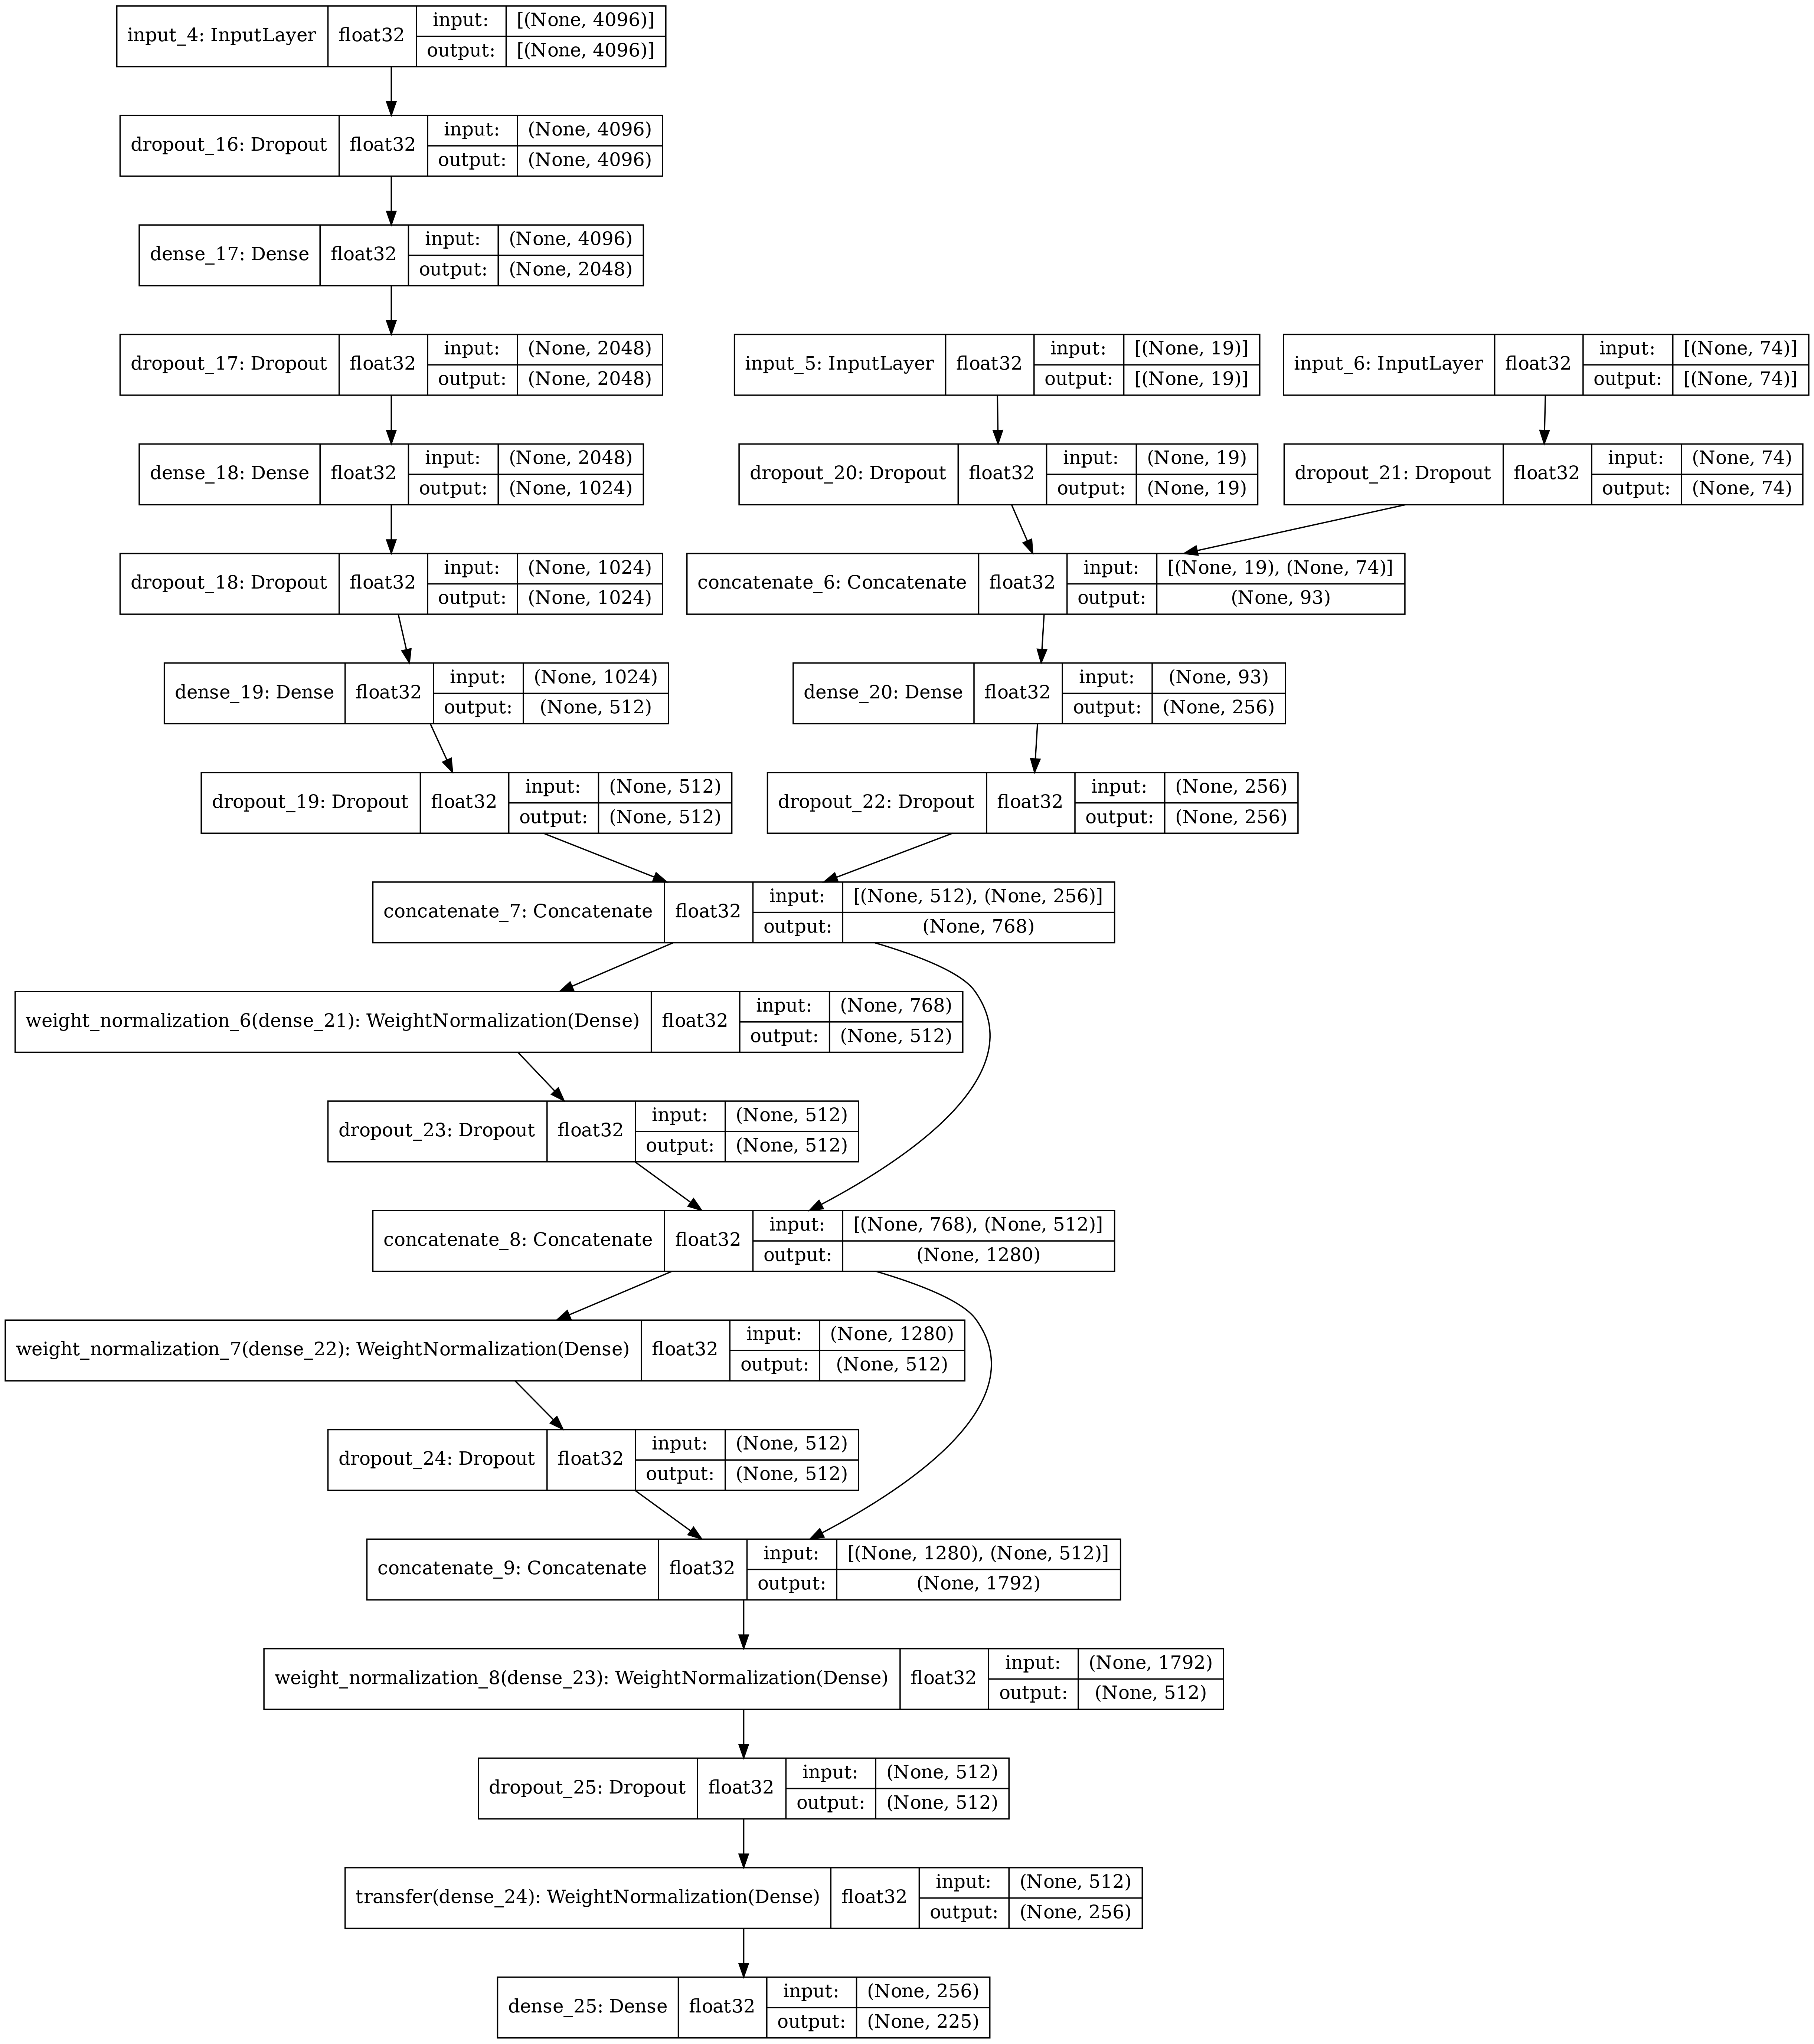

In [ ]:
createFolder(folder_path + "tmp_plot_model/")
model_img_path = folder_path + "tmp_plot_model/model_architecture.png"
tmp_model = [create_model_digit1(), create_model_digit2(), create_model_digit3()]
plot_model(tmp_model[2], to_file=model_img_path,
           show_shapes=True, show_dtype=True, expand_nested=True, dpi=256)

In [ ]:
model_size_dic = dict.fromkeys(["digit_1", "digit_2", "digit_3"])
model_size_dic["digit_1"] = (count_params(tmp_model[0].trainable_weights), count_params(tmp_model[0].non_trainable_weights))
model_size_dic["digit_2"] = (count_params(tmp_model[1].trainable_weights), count_params(tmp_model[1].non_trainable_weights))
model_size_dic["digit_3"] = (count_params(tmp_model[2].trainable_weights), count_params(tmp_model[2].non_trainable_weights))
del tmp_model

# Define Tasks

In [ ]:
# class task_classifier(tf.keras.layers.Layer, base.Task):
#     def __init__(
#         self,
#         loss,
#         metrics=None,
#         prediction_metrics=None,
#         label_metrics=None,
#         loss_metrics=None,
#         name=None):
#         """Initializes the task.
#         Args:
#         loss: Loss function. Defaults to BinaryCrossentropy.
#         metrics: List of Keras metrics to be evaluated.
#         prediction_metrics: List of Keras metrics used to summarize the
#         predictions.
#         label_metrics: List of Keras metrics used to summarize the labels.
#         loss_metrics: List of Keras metrics used to summarize the loss.
#         name: Optional task name.
#         """
#         super().__init__(name=name)

#         self._loss = (loss if loss is not None else tf.keras.losses.BinaryCrossentropy())
#         self._ranking_metrics = metrics or []
#         self._prediction_metrics = prediction_metrics or []
#         self._label_metrics = label_metrics or []
#         self._loss_metrics = loss_metrics or []

#     def call(
#         self,
#         labels,
#         predictions,
#         sample_weight=None,
#         training=False,
#         compute_metrics=True):
#         """Computes the task loss and metrics.
#         Args:
#         labels: Tensor of labels.
#         predictions: Tensor of predictions.
#         sample_weight: Tensor of sample weights.
#         training: Indicator whether training or test loss is being computed.
#         compute_metrics: Whether to compute metrics. Set this to False
#         during training for faster training.
#         Returns:
#         loss: Tensor of loss values.
#         """
#         loss = self._loss(y_true=labels, y_pred=predictions, sample_weight=sample_weight)
#         if not compute_metrics:
#             return loss
#         update_ops = []

#         for metric in self._ranking_metrics:
#             update_ops.append(metric.update_state(
#                 y_true=labels, y_pred=predictions, sample_weight=sample_weight))

#         for metric in self._prediction_metrics:
#             update_ops.append(
#                 metric.update_state(predictions, sample_weight=sample_weight))

#         for metric in self._label_metrics:
#             update_ops.append(
#                 metric.update_state(labels, sample_weight=sample_weight))

#         for metric in self._loss_metrics:
#             update_ops.append(
#                 metric.update_state(loss, sample_weight=sample_weight))

#         # Custom metrics may not return update ops, unlike built-in
#         # Keras metrics.
#         update_ops = [x for x in update_ops if x is not None]

#         with tf.control_dependencies(update_ops):
#             return tf.identity(loss)

In [ ]:
# class task_average_acc(tf.keras.layers.Layer, base.Task):
#     def __init__(
#         self,
#         loss,
#         metrics=None,
#         prediction_metrics=None,
#         label_metrics=None,
#         loss_metrics=None,
#         name=None):
#         """Initializes the task.
#         Args:
#         loss: Loss function. Defaults to BinaryCrossentropy.
#         metrics: List of Keras metrics to be evaluated.
#         prediction_metrics: List of Keras metrics used to summarize the
#         predictions.
#         label_metrics: List of Keras metrics used to summarize the labels.
#         loss_metrics: List of Keras metrics used to summarize the loss.
#         name: Optional task name.
#         """
#         super().__init__(name=name)
#         self._loss = (loss if loss is not None else tf.keras.losses.BinaryCrossentropy())
#         self._ranking_metrics = [tf.keras.metrics.Mean(name="average_acc")]

#     def call(
#         self,
#         acc_values,
#         sample_weight,
#         training=False,
#         compute_metrics=True):
#         """Computes the task loss and metrics.
#         Args:
#         labels: Tensor of labels.
#         predictions: Tensor of predictions.
#         sample_weight: Tensor of sample weights.
#         training: Indicator whether training or test loss is being computed.
#         compute_metrics: Whether to compute metrics. Set this to False
#         during training for faster training.
#         Returns:
#         loss: Tensor of loss values.
#         """
#         # loss = self._loss(y_true=labels, y_pred=predictions, sample_weight=sample_weight)
#         loss = 0.0
#         if not compute_metrics:
#             return loss
#         update_ops = []
#         for metric in self._ranking_metrics:
#             update_ops.append(metric.update_state(values=acc_values, sample_weight=sample_weight))

#         # Custom metrics may not return update ops, unlike built-in
#         # Keras metrics.
#         update_ops = [x for x in update_ops if x is not None]

#         with tf.control_dependencies(update_ops):
#             return tf.identity(loss)

In [ ]:
# class Model_Mutlitask(tfrs.models.Model):
#     def __init__(self, loss_weight=(1.0, 1.0, 1.0)):
#         # We take the loss weights in the constructor: this allows us to instantiate
#         # several model objects with different loss weights.
#         super().__init__()
#         self.model_digit1 = create_model_digit1()
#         self.model_digit2 = create_model_digit2()
#         self.model_digit3 = create_model_digit3()
#         # self.model_digit1 = create_classifier(len(target_encoder.dic_cat["digit_1"].keys()))
#         # self.model_digit2 = create_classifier(len(target_encoder.dic_cat["digit_2"].keys()))
#         # self.model_digit3 = create_classifier(len(target_encoder.dic_cat["digit_3"].keys()))
#         self.task_digit1 = task_classifier(
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(name="digit1_loss"),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="digit1_acc")]
#         )
#         self.task_digit2 = task_classifier(
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(name="digit2_loss"),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="digit2_acc")]
#         )
#         self.task_digit3 = task_classifier(
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(name="digit3_loss"),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="digit3_acc")]
#         )
#         self.metric_average = task_average_acc(
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(name="none"),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="average_acc")]
#         )
#         self.loss_weight = loss_weight
#     def compute_loss(self, features, training=False):
#         softmax_digit1 = self.model_digit1(features[0])
#         digit2_input = Model(self.model_digit1.get_layer(index=1).output, self.model_digit1.get_layer(name="transfer_dense1").output)(features[0])
#         softmax_digit2 = self.model_digit2(digit2_input)
#         digit3_input = Model(self.model_digit2.get_layer(index=1).output, self.model_digit2.get_layer(name="transfer_dense2").output)(digit2_input)
#         softmax_digit3 = self.model_digit3(digit3_input)
        
#         loss_digit1 = self.task_digit1(predictions=softmax_digit1, labels=features[1][0], sample_weight=None)
#         loss_digit2 = self.task_digit2(predictions=softmax_digit2, labels=features[1][1], sample_weight=None)
#         loss_digit3 = self.task_digit3(predictions=softmax_digit3, labels=features[1][2], sample_weight=None)
#         metric_value = [
#             self.task_digit1._ranking_metrics[0].result(),
#             self.task_digit2._ranking_metrics[0].result(),
#             self.task_digit3._ranking_metrics[0].result()
#         ]
#         self.metric_average(metric_value, sample_weight=self.loss_weight)

#         return (loss_digit1*self.loss_weight[0] + loss_digit2*self.loss_weight[1] + loss_digit3*self.loss_weight[2])

# Fold Training

In [ ]:
#### learning parameter setting
epochs = 100
patient_epochs = max(int(epochs * 0.2), 10)
patient_lr = 2
batch_size = 256
eta = 1e-3
weight_decay = 1e-5
optimizer_name = "AdamW"
# optimizer_name = "Adam"
checkpoint_filepath = './tmp_checkpoint/fold_checkpoint'

# model_list = dict.fromkeys(["digit_1", "digit_2", "digit_3"])
history_list = dict.fromkeys(["digit_1", "digit_2", "digit_3"])
for i in history_list.keys():
    history_list[i] = []
fold_metric = dict.fromkeys(["digit_1", "digit_2", "digit_3"])
for i in fold_metric.keys():
    fold_metric[i] = []

result_prob = dict.fromkeys(["digit_1", "digit_2", "digit_3"])
result_prob["digit_1"] = np.zeros(shape=(test_x.shape[0], len(target_encoder.dic_cat["digit_1"].keys())))
result_prob["digit_2"] = np.zeros(shape=(test_x.shape[0], len(target_encoder.dic_cat["digit_2"].keys())))
result_prob["digit_3"] = np.zeros(shape=(test_x.shape[0], len(target_encoder.dic_cat["digit_3"].keys())))

# Training - seperated label encoding

In [ ]:
# def stage_learning(fold, train_idx, val_idx, stage=1, history_list=None, fold_metric=None, additional_input=None):
#     print("Stage", stage)
#     output = {}

#     if stage == 1:
#         tmp_doc_embed = []
#         for i in text_vars:
#             with tf.device('/CPU:0'):
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[train_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))  
#         train_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_1"]].iloc[train_idx].astype("float32"), batch_size, True)

#         tmp_doc_embed = []
#         for i in text_vars:
#             with tf.device('/CPU:0'):
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[val_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))  
#         val_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_1"]].iloc[val_idx], batch_size, False)

#         cb_tensorboard = tf_callbacks.TensorBoard(log_dir="./tmp_tb", histogram_freq=1)
#         try:
#             wandb.tensorboard.patch(root_logdir="./tmp_tb")
#         except:
#             pass
#         wandb.init(
#             project="KOSTAT_IndustrialStandard_" + model_name,
#             group="base_line_scaleup_dropout0.5" + "stage_" + str(stage),
#             name="fold_" + str(fold)
#         ); wandb.config.step = 0
        
#         cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
#         cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=patient_lr, factor=0.5, min_lr=1e-5)
#         cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

#         model = create_model_digit1()
#         model.compile(
#             optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
#         )

#         print("start training")
#         history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
#                 callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, cb_tensorboard, TqdmCallback(verbose=1)])

#         model.load_weights(checkpoint_filepath)
#         print("end training")
#         # model_list.append(model)

#         history_list.append(history)
#         fold_metric.append(model.evaluate(val_ds, return_dict=True))
#         # print(fold_metric[-1]["digit3_acc"])
#         # fold_metric[-1]["equal_weighted_average_acc"] = np.mean([fold_metric[-1]["digit1_acc"], fold_metric[-1]["digit2_acc"], fold_metric[-1]["digit3_acc"]])

#         output["train"] = model.predict(train_ds)
#         output["val"] = model.predict(val_ds)
#         del train_ds, val_ds

#         tmp_doc_embed = []
#         for i in text_vars:
#             with tf.device('/CPU:0'):
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(test_x[i].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))  
#         test_ds = create_dataset(tuple(tmp_doc_embed), None, batch_size, False)

#         prob = model.predict(test_ds)
#         output["test"] = prob
#         result_prob["digit_1"] += prob / n_folds
#         # result_prob["digit_2"] += prob2 / n_folds
#         # result_prob["digit_3"] += prob3 / n_folds
        
#         wandb.log({"fold": fold, "acc_stage_1": fold_metric[-1]["acc"]})
#         wandb.finish() 
#     elif stage == 2:
#         tmp_doc_embed = []
#         for i in text_vars:
#             with tf.device('/CPU:0'):
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[train_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#         tmp_doc_embed.append(additional_input["train"])
#         train_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_2"]].iloc[train_idx].astype("float32"), batch_size, True)

#         tmp_doc_embed = []
#         for i in text_vars:
#             with tf.device('/CPU:0'):
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[val_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#         tmp_doc_embed.append(additional_input["val"])
#         val_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_2"]].iloc[val_idx], batch_size, False)

#         cb_tensorboard = tf_callbacks.TensorBoard(log_dir="./tmp_tb", histogram_freq=1)
#         try:
#             wandb.tensorboard.patch(root_logdir="./tmp_tb")
#         except:
#             pass
#         wandb.init(
#             project="KOSTAT_IndustrialStandard_" + model_name,
#             group="base_line_scaleup_dropout0.5" + "stage_" + str(stage),
#             name="fold_" + str(fold)
#         ); wandb.config.step = 0
        
#         cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
#         cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=patient_lr, factor=0.5, min_lr=1e-5)
#         cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

#         model = create_model_digit2()
#         model.compile(
#             optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
#         )

#         print("start training")
#         history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
#                 callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, cb_tensorboard, TqdmCallback(verbose=1)])
#         model.load_weights(checkpoint_filepath)
#         print("end training")
#         # model_list.append(model)

#         history_list.append(history)
#         fold_metric.append(model.evaluate(val_ds, return_dict=True))
#         # print(fold_metric[-1]["digit3_acc"])
#         # fold_metric[-1]["equal_weighted_average_acc"] = np.mean([fold_metric[-1]["digit1_acc"], fold_metric[-1]["digit2_acc"], fold_metric[-1]["digit3_acc"]])

#         output["train"] = model.predict(train_ds)
#         output["train"] = np.concatenate([output["train"], additional_input["train"]], axis=1)
#         output["val"] = model.predict(val_ds)
#         output["val"] = np.concatenate([output["val"], additional_input["val"]], axis=1)
#         del train_ds, val_ds

#         tmp_doc_embed = []
#         for i in text_vars:
#             with tf.device('/CPU:0'):
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(test_x[i].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#         tmp_doc_embed.append(additional_input["test"])
#         test_ds = create_dataset(tuple(tmp_doc_embed), None, batch_size, False)

#         prob = model.predict(test_ds)
#         output["test"] = prob
#         output["test"] = np.concatenate([output["test"], additional_input["test"]], axis=1)
#         result_prob["digit_2"] += prob / n_folds
        
#         wandb.log({"fold": fold, "acc_stage_2": fold_metric[-1]["acc"]})
#         wandb.finish()
#     elif stage == 3:
#         tmp_doc_embed = []
#         for i in text_vars:
#             with tf.device('/CPU:0'):
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[train_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#         tmp_doc_embed.append(additional_input["train"])
#         train_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_3"]].iloc[train_idx].astype("float32"), batch_size, True)

#         tmp_doc_embed = []
#         for i in text_vars:
#             with tf.device('/CPU:0'):
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[val_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#         tmp_doc_embed.append(additional_input["val"])
#         val_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_3"]].iloc[val_idx], batch_size, False)

#         cb_tensorboard = tf_callbacks.TensorBoard(log_dir="./tmp_tb", histogram_freq=1)
#         try:
#             wandb.tensorboard.patch(root_logdir="./tmp_tb")
#         except:
#             pass
#         wandb.init(
#             project="KOSTAT_IndustrialStandard_" + model_name,
#             group="base_line_scaleup_dropout0.5" + "stage_" + str(stage),
#             name="fold_" + str(fold)
#         ); wandb.config.step = 0
        
#         cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
#         cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=patient_lr, factor=0.5, min_lr=1e-5)
#         cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

#         model = create_model_digit3()
#         model.compile(
#             optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
#         )

#         print("start training")
#         history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
#                 callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, cb_tensorboard, TqdmCallback(verbose=1)])
#         model.load_weights(checkpoint_filepath)
#         print("end training")
#         # model_list.append(model)

#         history_list.append(history)
#         fold_metric.append(model.evaluate(val_ds, return_dict=True))
#         # print(fold_metric[-1]["digit3_acc"])
#         # fold_metric[-1]["equal_weighted_average_acc"] = np.mean([fold_metric[-1]["digit1_acc"], fold_metric[-1]["digit2_acc"], fold_metric[-1]["digit3_acc"]])

#         output["train"] = model.predict(train_ds)
#         output["val"] = model.predict(val_ds)
#         del train_ds, val_ds

#         tmp_doc_embed = []
#         for i in text_vars:
#             with tf.device('/CPU:0'):
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(test_x[i].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#         tmp_doc_embed.append(additional_input["test"])
#         test_ds = create_dataset(tuple(tmp_doc_embed), None, batch_size, False)

#         prob = model.predict(test_ds)
#         output["test"] = prob
#         result_prob["digit_3"] += prob / n_folds
        
#         wandb.log({"fold": fold, "acc_stage_3": fold_metric[-1]["acc"]})
#         wandb.finish()
#     return output

# Training - label encoding + TF IDF

In [ ]:
# def stage_learning(fold, train_idx, val_idx, stage=1, history_list=None, fold_metric=None, additional_input=None):
#     print("=== Stage", stage, "===")
#     output = {}

#     if stage == 1:
#         tmp_doc_embed = []
#         with tf.device('/CPU:0'):
#             for i in text_vars:     
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[train_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#             tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[train_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
#         train_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_1"]].iloc[train_idx].astype("float32"), batch_size, True)

#         tmp_doc_embed = []
#         with tf.device('/CPU:0'):
#             for i in text_vars:
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[val_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))  
#             tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[val_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
#         val_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_1"]].iloc[val_idx], batch_size, False)

#         cb_tensorboard = tf_callbacks.TensorBoard(log_dir="./tmp_tb", histogram_freq=1)
#         try:
#             wandb.tensorboard.patch(root_logdir="./tmp_tb")
#         except:
#             pass
#         wandb.init(
#             project="KOSTAT_IndustrialStandard_" + model_name,
#             group=group_name + "stage_" + str(stage),
#             name="fold_" + str(fold)
#         ); wandb.config.step = 0
        
#         cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
#         cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=patient_lr, factor=0.5, min_lr=1e-5)
#         cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

#         model = create_model_digit1()
#         model.compile(
#             optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
#         )

#         print("start training")
#         history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
#                 callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, cb_tensorboard, TqdmCallback(verbose=1)])

#         model.load_weights(checkpoint_filepath)
#         print("end training")
#         # model_list.append(model)

#         history_list.append(history)
#         fold_metric.append(model.evaluate(val_ds, return_dict=True))
#         # print(fold_metric[-1]["digit3_acc"])
#         # fold_metric[-1]["equal_weighted_average_acc"] = np.mean([fold_metric[-1]["digit1_acc"], fold_metric[-1]["digit2_acc"], fold_metric[-1]["digit3_acc"]])

#         output["train"] = model.predict(train_ds)
#         output["val"] = model.predict(val_ds)
#         del train_ds, val_ds

#         tmp_doc_embed = []
#         with tf.device('/CPU:0'):
#             for i in text_vars:
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(test_x[i].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#             tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(test_x["sentence"].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
#         test_ds = create_dataset(tuple(tmp_doc_embed), None, batch_size, False)

#         prob = model.predict(test_ds)
#         output["test"] = prob
#         result_prob["digit_1"] += prob / n_folds
#         # result_prob["digit_2"] += prob2 / n_folds
#         # result_prob["digit_3"] += prob3 / n_folds
        
#         wandb.log({"fold": fold, "acc_stage_1": fold_metric[-1]["acc"]})
#         wandb.finish() 
#     elif stage == 2:
#         tmp_doc_embed = []
#         with tf.device('/CPU:0'):
#             for i in text_vars:     
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[train_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#             tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[train_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
#             tmp_doc_embed.append(additional_input["train"])
#         train_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_2"]].iloc[train_idx].astype("float32"), batch_size, True)

#         tmp_doc_embed = []
#         with tf.device('/CPU:0'):
#             for i in text_vars:
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[val_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))  
#             tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[val_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
#             tmp_doc_embed.append(additional_input["val"])
#         val_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_2"]].iloc[val_idx], batch_size, False)

#         cb_tensorboard = tf_callbacks.TensorBoard(log_dir="./tmp_tb", histogram_freq=1)
#         try:
#             wandb.tensorboard.patch(root_logdir="./tmp_tb")
#         except:
#             pass
#         wandb.init(
#             project="KOSTAT_IndustrialStandard_" + model_name,
#             group=group_name + "stage_" + str(stage),
#             name="fold_" + str(fold)
#         ); wandb.config.step = 0
        
#         cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
#         cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=patient_lr, factor=0.5, min_lr=1e-5)
#         cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

#         model = create_model_digit2()
#         model.compile(
#             optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
#         )

#         print("start training")
#         history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
#                 callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, cb_tensorboard, TqdmCallback(verbose=1)])
#         model.load_weights(checkpoint_filepath)
#         print("end training")
#         # model_list.append(model)

#         history_list.append(history)
#         fold_metric.append(model.evaluate(val_ds, return_dict=True))
#         # print(fold_metric[-1]["digit3_acc"])
#         # fold_metric[-1]["equal_weighted_average_acc"] = np.mean([fold_metric[-1]["digit1_acc"], fold_metric[-1]["digit2_acc"], fold_metric[-1]["digit3_acc"]])

#         output["train"] = model.predict(train_ds)
#         output["train"] = np.concatenate([output["train"], additional_input["train"]], axis=1)
#         output["val"] = model.predict(val_ds)
#         output["val"] = np.concatenate([output["val"], additional_input["val"]], axis=1)
#         del train_ds, val_ds

#         tmp_doc_embed = []
#         with tf.device('/CPU:0'):
#             for i in text_vars:
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(test_x[i].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#             tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(test_x["sentence"].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
#             tmp_doc_embed.append(additional_input["test"])
#         test_ds = create_dataset(tuple(tmp_doc_embed), None, batch_size, False)

#         prob = model.predict(test_ds)
#         output["test"] = prob
#         output["test"] = np.concatenate([output["test"], additional_input["test"]], axis=1)
#         result_prob["digit_2"] += prob / n_folds
        
#         wandb.log({"fold": fold, "acc_stage_2": fold_metric[-1]["acc"]})
#         wandb.finish()
#     elif stage == 3:
#         tmp_doc_embed = []
#         with tf.device('/CPU:0'):
#             for i in text_vars:     
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[train_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#             tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[train_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
#             tmp_doc_embed.append(additional_input["train"])
#         train_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_3"]].iloc[train_idx].astype("float32"), batch_size, True)

#         tmp_doc_embed = []
#         with tf.device('/CPU:0'):
#             for i in text_vars:
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[val_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))  
#             tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[val_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
#             tmp_doc_embed.append(additional_input["val"])
#         val_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_3"]].iloc[val_idx], batch_size, False)

#         cb_tensorboard = tf_callbacks.TensorBoard(log_dir="./tmp_tb", histogram_freq=1)
#         try:
#             wandb.tensorboard.patch(root_logdir="./tmp_tb")
#         except:
#             pass
#         wandb.init(
#             project="KOSTAT_IndustrialStandard_" + model_name,
#             group=group_name + "stage_" + str(stage),
#             name="fold_" + str(fold)
#         ); wandb.config.step = 0
        
#         cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
#         cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=patient_lr, factor=0.5, min_lr=1e-5)
#         cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

#         model = create_model_digit3()
#         model.compile(
#             optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
#         )

#         print("start training")
#         history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
#                 callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, cb_tensorboard, TqdmCallback(verbose=1)])
#         model.load_weights(checkpoint_filepath)
#         print("end training")
#         # model_list.append(model)

#         history_list.append(history)
#         fold_metric.append(model.evaluate(val_ds, return_dict=True))
#         # print(fold_metric[-1]["digit3_acc"])
#         # fold_metric[-1]["equal_weighted_average_acc"] = np.mean([fold_metric[-1]["digit1_acc"], fold_metric[-1]["digit2_acc"], fold_metric[-1]["digit3_acc"]])

#         output["train"] = model.predict(train_ds)
#         output["val"] = model.predict(val_ds)
#         del train_ds, val_ds

#         tmp_doc_embed = []
#         with tf.device('/CPU:0'):
#             for i in text_vars:
#                 doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
#                 tmp_doc_embed.append(pad_sequences(doc_vectorize(test_x[i].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
#             tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(test_x["sentence"].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
#             tmp_doc_embed.append(additional_input["test"])
#         test_ds = create_dataset(tuple(tmp_doc_embed), None, batch_size, False)

#         prob = model.predict(test_ds)
#         output["test"] = prob
#         result_prob["digit_3"] += prob / n_folds
        
#         wandb.log({"fold": fold, "acc_stage_3": fold_metric[-1]["acc"]})
#         wandb.finish()
#     return output

# Training - TF IDF

In [ ]:
def stage_learning(fold, train_idx, val_idx, stage=1, history_list=None, fold_metric=None, additional_input=None):
    print("=== Stage", stage, "===")
    output = {}

    if stage == 1:
        tmp_doc_embed = []
        with tf.device('/CPU:0'):
            # for i in text_vars:     
            #     doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
            #     tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[train_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
            tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[train_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
        train_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_1"]].iloc[train_idx].astype("float32"), batch_size, True)

        tmp_doc_embed = []
        with tf.device('/CPU:0'):
            # for i in text_vars:
            #     doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
            #     tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[val_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))  
            tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[val_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
        val_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_1"]].iloc[val_idx], batch_size, False)

        cb_tensorboard = tf_callbacks.TensorBoard(log_dir="./tmp_tb", histogram_freq=1)
        try:
            wandb.tensorboard.patch(root_logdir="./tmp_tb")
        except:
            pass
        wandb.init(
            project="KOSTAT_IndustrialStandard_" + model_name,
            group=group_name + "stage_" + str(stage),
            name="fold_" + str(fold)
        ); wandb.config.step = 0
        
        cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
        cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=patient_lr, factor=0.5, min_lr=1e-5)
        cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

        model = create_model_digit1()
        model.compile(
            optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
            # optimizer=tf.keras.optimizers.Adam(learning_rate=eta),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
        )

        print("start training")
        history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
                callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, cb_tensorboard, TqdmCallback(verbose=0)])

        model.load_weights(checkpoint_filepath)
        print("end training")
        # model_list.append(model)

        history_list.append(history)
        fold_metric.append(model.evaluate(val_ds, return_dict=True))
        # print(fold_metric[-1]["digit3_acc"])
        # fold_metric[-1]["equal_weighted_average_acc"] = np.mean([fold_metric[-1]["digit1_acc"], fold_metric[-1]["digit2_acc"], fold_metric[-1]["digit3_acc"]])

        output["train"] = model.predict(train_ds)
        output["val"] = model.predict(val_ds)
        del train_ds, val_ds

        tmp_doc_embed = []
        with tf.device('/CPU:0'):
            # for i in text_vars:
            #     doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
            #     tmp_doc_embed.append(pad_sequences(doc_vectorize(test_x[i].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
            tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(test_x["sentence"].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
        test_ds = create_dataset(tuple(tmp_doc_embed), None, batch_size, False)

        prob = model.predict(test_ds)
        output["test"] = prob
        result_prob["digit_1"] += prob / n_folds
        # result_prob["digit_2"] += prob2 / n_folds
        # result_prob["digit_3"] += prob3 / n_folds
        
        wandb.log({"fold": fold, "acc_stage_1": fold_metric[-1]["acc"]})
        wandb.finish() 
    elif stage == 2:
        tmp_doc_embed = []
        with tf.device('/CPU:0'):
            # for i in text_vars:     
            #     doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
            #     tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[train_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
            tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[train_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
            tmp_doc_embed.append(additional_input["train"])
        train_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_2"]].iloc[train_idx].astype("float32"), batch_size, True)

        tmp_doc_embed = []
        with tf.device('/CPU:0'):
            # for i in text_vars:
            #     doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
            #     tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[val_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))  
            tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[val_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
            tmp_doc_embed.append(additional_input["val"])
        val_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_2"]].iloc[val_idx], batch_size, False)

        cb_tensorboard = tf_callbacks.TensorBoard(log_dir="./tmp_tb", histogram_freq=1)
        try:
            wandb.tensorboard.patch(root_logdir="./tmp_tb")
        except:
            pass
        wandb.init(
            project="KOSTAT_IndustrialStandard_" + model_name,
            group=group_name + "stage_" + str(stage),
            name="fold_" + str(fold)
        ); wandb.config.step = 0
        
        cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
        cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=patient_lr, factor=0.5, min_lr=1e-5)
        cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

        model = create_model_digit2()
        model.compile(
            optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
            # optimizer=tf.keras.optimizers.Adam(learning_rate=eta),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
        )

        print("start training")
        history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
                callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, cb_tensorboard, TqdmCallback(verbose=0)])
        model.load_weights(checkpoint_filepath)
        print("end training")
        # model_list.append(model)

        history_list.append(history)
        fold_metric.append(model.evaluate(val_ds, return_dict=True))
        # print(fold_metric[-1]["digit3_acc"])
        # fold_metric[-1]["equal_weighted_average_acc"] = np.mean([fold_metric[-1]["digit1_acc"], fold_metric[-1]["digit2_acc"], fold_metric[-1]["digit3_acc"]])

        output["train"] = model.predict(train_ds)
        output["train"] = (additional_input["train"], output["train"])
        output["val"] = model.predict(val_ds)
        output["val"] = (additional_input["val"], output["val"])
        del train_ds, val_ds

        tmp_doc_embed = []
        with tf.device('/CPU:0'):
            # for i in text_vars:
            #     doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
            #     tmp_doc_embed.append(pad_sequences(doc_vectorize(test_x[i].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
            tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(test_x["sentence"].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
            tmp_doc_embed.append(additional_input["test"])
        test_ds = create_dataset(tuple(tmp_doc_embed), None, batch_size, False)

        prob = model.predict(test_ds)
        output["test"] = prob
        output["test"] = (additional_input["test"], output["test"])
        result_prob["digit_2"] += prob / n_folds
        
        wandb.log({"fold": fold, "acc_stage_2": fold_metric[-1]["acc"]})
        wandb.finish()
    elif stage == 3:
        tmp_doc_embed = []
        with tf.device('/CPU:0'):
            # for i in text_vars:     
            #     doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
            #     tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[train_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
            tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[train_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
            tmp_doc_embed.append(additional_input["train"][0])
            tmp_doc_embed.append(additional_input["train"][1])
        train_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_3"]].iloc[train_idx].astype("float32"), batch_size, True)

        tmp_doc_embed = []
        with tf.device('/CPU:0'):
            # for i in text_vars:
            #     doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
            #     tmp_doc_embed.append(pad_sequences(doc_vectorize(full_x[i].iloc[val_idx].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))  
            tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(full_x["sentence"].iloc[val_idx].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
            tmp_doc_embed.append(additional_input["val"][0])
            tmp_doc_embed.append(additional_input["val"][1])
        val_ds = create_dataset(tuple(tmp_doc_embed), full_y[["digit_3"]].iloc[val_idx], batch_size, False)

        cb_tensorboard = tf_callbacks.TensorBoard(log_dir="./tmp_tb", histogram_freq=1)
        try:
            wandb.tensorboard.patch(root_logdir="./tmp_tb")
        except:
            pass
        wandb.init(
            project="KOSTAT_IndustrialStandard_" + model_name,
            group=group_name + "stage_" + str(stage),
            name="fold_" + str(fold)
        ); wandb.config.step = 0
        
        cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
        cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=patient_lr, factor=0.5, min_lr=1e-5)
        cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

        model = create_model_digit3()
        model.compile(
            optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
            # optimizer=tf.keras.optimizers.Adam(learning_rate=eta),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
        )

        print("start training")
        history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
                callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, cb_tensorboard, TqdmCallback(verbose=0)])
        model.load_weights(checkpoint_filepath)
        print("end training")
        # model_list.append(model)

        history_list.append(history)
        fold_metric.append(model.evaluate(val_ds, return_dict=True))
        # print(fold_metric[-1]["digit3_acc"])
        # fold_metric[-1]["equal_weighted_average_acc"] = np.mean([fold_metric[-1]["digit1_acc"], fold_metric[-1]["digit2_acc"], fold_metric[-1]["digit3_acc"]])

        # output["train"] = model.predict(train_ds)
        # output["val"] = model.predict(val_ds)
        del train_ds, val_ds

        tmp_doc_embed = []
        with tf.device('/CPU:0'):
            # for i in text_vars:
            #     doc_vectorize = load_model(os.path.join(folder_path, "models/vectorizer_int_" + i))
            #     tmp_doc_embed.append(pad_sequences(doc_vectorize(test_x[i].to_numpy()).numpy(), maxlen=embed_len, padding='pre', truncating='post'))
            tmp_doc_embed.append(pad_sequences(vectorizer_tfidf(test_x["sentence"].to_numpy()).numpy(), padding='pre').astype(dtype="float32"))
            tmp_doc_embed.append(additional_input["test"][0])
            tmp_doc_embed.append(additional_input["test"][1])
        test_ds = create_dataset(tuple(tmp_doc_embed), None, batch_size, False)

        prob = model.predict(test_ds)
        # output["test"] = prob
        result_prob["digit_3"] += prob / n_folds
        
        wandb.log({"fold": fold, "acc_stage_3": fold_metric[-1]["acc"]})
        wandb.finish()
    return output

# Run

In [ ]:
def do_fold_training(fold, train_idx, val_idx):
    tmp_time = time()

    output = stage_learning(fold, train_idx, val_idx, stage=1, history_list=history_list["digit_1"], fold_metric=fold_metric["digit_1"], additional_input=None)
    output = stage_learning(fold, train_idx, val_idx, stage=2, history_list=history_list["digit_2"], fold_metric=fold_metric["digit_2"], additional_input=output)
    output = stage_learning(fold, train_idx, val_idx, stage=3, history_list=history_list["digit_3"], fold_metric=fold_metric["digit_3"], additional_input=output)

    print("Fold " + str(fold) + " Time (minutes) : ", round((time() - tmp_time) / 60, 3))

In [ ]:
model_name = "NN_tfidf_stage_learning"
group_name = "scaleup_dropout0.25_tfidf_adamw_densenetSwish_"
seed_everything()

n_folds = 10
base_train_size = 1024
tr_size = base_train_size * 250
kfolds_spliter = StratifiedShuffleSplit(n_folds, train_size=tr_size, test_size=int(tr_size * 0.5), random_state=1004)

training_start = time()
# fold training
for fold, (train_idx, val_idx) in enumerate(kfolds_spliter.split(range(full_y.shape[0]), full_y["digit_1"])):
    print("\n===== Fold ", fold, "=====\n")
    start_mem = memory_usage()
    do_fold_training(fold, train_idx, val_idx)
    tf.keras.backend.clear_session()
    gc.collect()
    end_mem = memory_usage()
    print("@memory leaked ->", round(end_mem - start_mem, 3), "MB")
training_end = time()
print("@total training time ->", training_end - training_start)
training_total_time_minutes = round((training_end - training_start) / 60, 3)


===== Fold  0 =====

[debug] memory usage:   3620.789 MB
=== Stage 1 ===


wandb: Currently logged in as: frony (use `wandb login --relogin` to force relogin)


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1247 - acc: 0.9675



acc_stage_1,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇▇████████████████████████████
train/epoch_loss,█▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
validation/epoch_acc,▁▄▄▅▆▆▆▆▇▇▇██▇██████████████████████████
validation/epoch_loss,█▅▄▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▄▅▆▆▆▆▇▇▇██▇██████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2696 - acc: 0.9302



acc_stage_2,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇▇▇███████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
validation/epoch_acc,▁▄▅▆▆▇▇▇▇███████████████████████████████
validation/epoch_loss,█▅▄▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▆▆▇▇▇▇███████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.4142 - acc: 0.8974



acc_stage_3,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/epoch_acc,▁▄▅▆▆▆▆▆▇▇▇█████████████████████████████
train/epoch_loss,█▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
validation/epoch_acc,▁▄▅▆▆▇▇▇▇▇██████████████████████████████
validation/epoch_loss,█▅▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▆▆▇▇▇▇▇██████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 0 Time (minutes) :  52.576
[debug] memory usage:  20878.840 MB
@memory leaked -> 17258.051 MB

===== Fold  1 =====

[debug] memory usage:  20880.484 MB
=== Stage 1 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1293 - acc: 0.9664



acc_stage_1,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇██████████████████████████
train/epoch_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,██████████▄▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
validation/epoch_acc,▁▂▄▅▅▆▆▆▆▆▇▇▇███████████████████████████
validation/epoch_loss,█▅▄▃▃▂▂▂▂▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▂▄▅▅▆▆▆▆▆▇▇▇███████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▃▃▂▂▂▂▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2735 - acc: 0.9284



acc_stage_2,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/epoch_acc,▁▄▅▆▆▆▆▆▇▇▇█████████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
validation/epoch_acc,▁▄▅▅▆▆▆▇▇▇▇█████████████████████████████
validation/epoch_loss,█▅▄▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▅▆▆▆▇▇▇▇█████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 6ms/step - loss: 0.4175 - acc: 0.8964



acc_stage_3,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▇▇▇▇█████████████████████████████
train/epoch_loss,█▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,███████▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
validation/epoch_acc,▁▄▅▆▆▆▇▇▇███████████████████████████████
validation/epoch_loss,█▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▆▆▆▇▇▇███████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 1 Time (minutes) :  53.603
[debug] memory usage:  21096.344 MB
@memory leaked -> 215.859 MB

===== Fold  2 =====

[debug] memory usage:  21096.840 MB
=== Stage 1 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1252 - acc: 0.9678



acc_stage_1,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇█████████████████████████
train/epoch_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,██████████▄▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
validation/epoch_acc,▁▃▄▄▅▆▆▆▆▆▇▇▇▇██████████████████████████
validation/epoch_loss,█▅▄▄▃▃▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▄▄▅▆▆▆▆▆▇▇▇▇██████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▄▃▃▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2646 - acc: 0.9300



acc_stage_2,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇▇████████████████████████████
train/epoch_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
validation/epoch_acc,▁▄▅▅▆▆▇▇▇▇██████████████████████████████
validation/epoch_loss,█▆▄▄▃▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▅▆▆▇▇▇▇██████████████████████████████
validation/evaluation_loss_vs_iterations,█▆▄▄▃▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.4124 - acc: 0.8969



acc_stage_3,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▆▆▆▆▆▆▇▇▇████████████████████████████
train/epoch_loss,█▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
validation/epoch_acc,▁▄▄▆▆▆▆▇▇▇▇█████████████████████████████
validation/epoch_loss,█▅▄▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▄▆▆▆▆▇▇▇▇█████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 2 Time (minutes) :  49.641
[debug] memory usage:  21477.539 MB
@memory leaked -> 380.699 MB

===== Fold  3 =====

[debug] memory usage:  21477.547 MB
=== Stage 1 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1213 - acc: 0.9682



acc_stage_1,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████████████████████
train/epoch_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,██████████▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
validation/epoch_acc,▁▄▄▅▆▅▅▆▇▆▇▇▇▇▇███████████████████████
validation/epoch_loss,█▅▄▃▃▃▃▂▃▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▄▅▆▅▅▆▇▆▇▇▇▇▇███████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▃▃▃▃▂▃▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2672 - acc: 0.9295



acc_stage_2,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇▇▇███████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
validation/epoch_acc,▁▃▅▆▆▆▆▆▆▇▇█████████████████████████████
validation/epoch_loss,█▅▄▃▃▃▂▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▅▆▆▆▆▆▆▇▇█████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▃▃▃▂▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 6ms/step - loss: 0.4148 - acc: 0.8969



acc_stage_3,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▆▆▆▆▇▇▇▇█████████████████████████████
train/epoch_loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,███████▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
validation/epoch_acc,▁▄▆▆▆▇▇▇▇███████████████████████████████
validation/epoch_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▆▆▆▇▇▇▇███████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 3 Time (minutes) :  49.821
[debug] memory usage:  21874.465 MB
@memory leaked -> 396.918 MB

===== Fold  4 =====

[debug] memory usage:  21889.145 MB
=== Stage 1 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1209 - acc: 0.9678



acc_stage_1,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇▇████████████████████████████
train/epoch_loss,█▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
validation/epoch_acc,▁▃▄▄▆▆▆▆▇▇▇█▇███████████████████████████
validation/epoch_loss,█▆▄▄▃▃▃▃▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▄▄▆▆▆▆▇▇▇█▇███████████████████████████
validation/evaluation_loss_vs_iterations,█▆▄▄▃▃▃▃▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2704 - acc: 0.9296



acc_stage_2,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/epoch_acc,▁▄▅▅▆▆▆▆▆▇▇▇████████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
validation/epoch_acc,▁▃▄▆▆▆▇▇▇▇▇█████████████████████████████
validation/epoch_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▄▆▆▆▇▇▇▇▇█████████████████████████████
validation/evaluation_loss_vs_iterations,█▆▄▃▃▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 6ms/step - loss: 0.4179 - acc: 0.8966



acc_stage_3,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▆▇▇▇▇███████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,██████████▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation/epoch_acc,▁▃▅▆▆▆▆▇▇▇▇█▇███████████████████████████
validation/epoch_loss,█▅▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▅▆▆▆▆▇▇▇▇█▇███████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 4 Time (minutes) :  52.503
[debug] memory usage:  21746.703 MB
@memory leaked -> -142.441 MB

===== Fold  5 =====

[debug] memory usage:  21748.996 MB
=== Stage 1 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1224 - acc: 0.9680



acc_stage_1,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▅▅▅▆▆▆▇▇▇▇▇▇███████████████████████████
train/epoch_loss,█▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,███████▄▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
validation/epoch_acc,▁▃▅▅▅▅▆▇▇▇▇▇▇███████████████████████████
validation/epoch_loss,█▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▅▅▅▅▆▇▇▇▇▇▇███████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2717 - acc: 0.9287



acc_stage_2,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇▇████████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
validation/epoch_acc,▁▄▅▆▆▆▇▇▇█▇█████████████████████████████
validation/epoch_loss,█▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▆▆▆▇▇▇█▇█████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.4161 - acc: 0.8964



acc_stage_3,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇█████████████████████████████
train/epoch_loss,█▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation/epoch_acc,▁▄▆▆▆▆▇▇▇▇██████████████████████████████
validation/epoch_loss,█▅▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▆▆▆▆▇▇▇▇██████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 5 Time (minutes) :  50.826
[debug] memory usage:  21922.598 MB
@memory leaked -> 173.602 MB

===== Fold  6 =====

[debug] memory usage:  21936.777 MB
=== Stage 1 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1208 - acc: 0.9680



acc_stage_1,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▅▅▅▆▆▆▆▆▇▇▇▇▇██████████████████████████
train/epoch_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
validation/epoch_acc,▁▄▄▄▅▆▆▆▆▇▇▇████████████████████████████
validation/epoch_loss,█▅▄▄▃▃▃▃▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▄▄▅▆▆▆▆▇▇▇████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▄▃▃▃▃▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2623 - acc: 0.9301



acc_stage_2,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/epoch_acc,▁▄▅▆▆▆▆▇▇▇▇█████████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,███████▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
validation/epoch_acc,▁▄▅▆▆▆▆▇▇███████████████████████████████
validation/epoch_loss,█▅▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▆▆▆▆▇▇███████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 6ms/step - loss: 0.4078 - acc: 0.8984



acc_stage_3,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇▇████████████████████████████
train/epoch_loss,█▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
validation/epoch_acc,▁▄▆▆▆▆▇▇▇▇▇█████████████████████████████
validation/epoch_loss,█▅▃▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▆▆▆▆▇▇▇▇▇█████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 6 Time (minutes) :  51.393
[debug] memory usage:  21189.531 MB
@memory leaked -> -747.246 MB

===== Fold  7 =====

[debug] memory usage:  21200.234 MB
=== Stage 1 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1204 - acc: 0.9687



acc_stage_1,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▆▇▇▇▇███████████████████████████
train/epoch_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
validation/epoch_acc,▁▃▄▄▅▅▆▆▆▇▇▇▇███████████████████████████
validation/epoch_loss,█▅▅▄▃▃▂▃▃▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▄▄▅▅▆▆▆▇▇▇▇███████████████████████████
validation/evaluation_loss_vs_iterations,█▅▅▄▃▃▂▃▃▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2683 - acc: 0.9300



acc_stage_2,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇▇████████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
validation/epoch_acc,▁▄▅▅▆▆▆▆▇▇██▇███████████████████████████
validation/epoch_loss,█▅▄▃▃▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▅▆▆▆▆▇▇██▇███████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▃▃▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.4118 - acc: 0.8976



acc_stage_3,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▆▆▆▆▆▇▇▇█████████████████████████████
train/epoch_loss,█▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
validation/epoch_acc,▁▄▅▆▆▆▇▇▇▇██████████████████████████████
validation/epoch_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▆▆▆▇▇▇▇██████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 7 Time (minutes) :  51.779
[debug] memory usage:  22044.965 MB
@memory leaked -> 844.73 MB

===== Fold  8 =====

[debug] memory usage:  22059.570 MB
=== Stage 1 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1216 - acc: 0.9675



acc_stage_1,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▅▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████████
train/epoch_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,████████▄▄▄▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
validation/epoch_acc,▁▃▄▄▅▅▅▅▇▇▇███▇▇▇██████████████████
validation/epoch_loss,█▅▅▄▃▃▃▃▁▁▂▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▄▄▅▅▅▅▇▇▇███▇▇▇██████████████████
validation/evaluation_loss_vs_iterations,█▅▅▄▃▃▃▃▁▁▂▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2681 - acc: 0.9289



acc_stage_2,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▆▇▇▇████████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
validation/epoch_acc,▁▄▄▆▆▇▇▇▇▇██████████████████████████████
validation/epoch_loss,█▅▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▄▆▆▇▇▇▇▇██████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.4088 - acc: 0.8973



acc_stage_3,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/epoch_acc,▁▄▅▆▆▆▆▇▇▇██████████████████████████████
train/epoch_loss,█▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,███████▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation/epoch_acc,▁▃▅▆▆▆▇▇████████████████████████████████
validation/epoch_loss,█▅▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▅▆▆▆▇▇████████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 8 Time (minutes) :  50.204
[debug] memory usage:  21750.707 MB
@memory leaked -> -308.863 MB

===== Fold  9 =====

[debug] memory usage:  21761.012 MB
=== Stage 1 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.1235 - acc: 0.9676



acc_stage_1,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▅▅▅▆▆▆▆▇▇▇▇▇▇██████████████████████████
train/epoch_loss,█▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
validation/epoch_acc,▁▃▄▅▅▆▆▆▆▇▇▇▇███████████████████████████
validation/epoch_loss,█▅▄▄▃▃▃▂▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▄▅▅▆▆▆▆▇▇▇▇███████████████████████████
validation/evaluation_loss_vs_iterations,█▅▄▄▃▃▃▂▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 2 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 5ms/step - loss: 0.2681 - acc: 0.9296



acc_stage_2,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▅▆▆▆▆▇▇▇▇████████████████████████████
train/epoch_loss,█▅▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,█████████▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
validation/epoch_acc,▁▃▅▆▆▆▆▇▆▇▇█████████████████████████████
validation/epoch_loss,█▅▃▃▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▃▅▆▆▆▆▇▆▇▇█████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▃▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


=== Stage 3 ===


start training


0epoch [00:00, ?epoch/s]

end training
500/500 [==============================] - 5s 6ms/step - loss: 0.4109 - acc: 0.8976



acc_stage_3,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_acc,▁▄▅▆▆▆▆▇▇▇▇█████████████████████████████
train/epoch_loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_lr,███████▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
validation/epoch_acc,▁▄▅▆▆▆▆▇▇███████████████████████████████
validation/epoch_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_acc_vs_iterations,▁▄▅▆▆▆▆▇▇███████████████████████████████
validation/evaluation_loss_vs_iterations,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Fold 9 Time (minutes) :  56.372
[debug] memory usage:  22117.777 MB
@memory leaked -> 356.766 MB
@total training time -> 31132.41786623001


# validation score summary

In [ ]:
wandb.init(
    project="KOSTAT_IndustrialStandard_" + model_name,
    group=group_name,
    name="summary"
); wandb.config.step = 0

In [ ]:
equal_weighted_score = np.mean([
    np.mean([fold_metric["digit_1"][i]["acc"] for i in range(n_folds)]),
    np.mean([fold_metric["digit_2"][i]["acc"] for i in range(n_folds)]),
    np.mean([fold_metric["digit_3"][i]["acc"] for i in range(n_folds)])
])
total_num_classes = len(target_encoder.dic_cat["digit_1"]) + len(target_encoder.dic_cat["digit_2"]) + len(target_encoder.dic_cat["digit_3"])
macro_acc = np.sum([
    np.mean([fold_metric["digit_1"][i]["acc"] for i in range(n_folds)]) * (len(target_encoder.dic_cat["digit_1"]) / total_num_classes),
    np.mean([fold_metric["digit_2"][i]["acc"] for i in range(n_folds)]) * (len(target_encoder.dic_cat["digit_2"]) / total_num_classes),
    np.mean([fold_metric["digit_3"][i]["acc"] for i in range(n_folds)]) * (len(target_encoder.dic_cat["digit_3"]) / total_num_classes)          
])
equal_weighted_loss = np.mean([
    np.mean([fold_metric["digit_1"][i]["loss"] for i in range(n_folds)]),
    np.mean([fold_metric["digit_2"][i]["loss"] for i in range(n_folds)]),
    np.mean([fold_metric["digit_3"][i]["loss"] for i in range(n_folds)])
])

In [ ]:
trainable_count = np.sum([i[0] for i in model_size_dic.values()])
non_trainable_count = np.sum([i[1] for i in model_size_dic.values()])
score_per_minutes = equal_weighted_score / (training_start / 60)
score_per_milparams = equal_weighted_score / (trainable_count / 1e+6)
wandb.log({"epochs": epochs, "patient_epochs": patient_epochs, "batch_size": batch_size, "patient_lr": patient_lr,
           "optimizer": optimizer_name, "eta": eta, "weight_decay": weight_decay, "dropoutRate": dropoutRate, "training_total_time_minutes": training_total_time_minutes,
           "model_img_path": wandb.Image(model_img_path), "total_params": trainable_count + non_trainable_count, "trainable_count": trainable_count, "non_trainable_count": non_trainable_count,
           "macro_acc": macro_acc,"equal_weighted_loss": equal_weighted_loss, "equal_weighted_score": equal_weighted_score, "score_per_minutes": score_per_minutes, "score_per_milparams": score_per_milparams})

In [ ]:
wandb.finish()

batch_size,▁
dropoutRate,▁
epochs,▁
equal_weighted_loss,▁
equal_weighted_score,▁
eta,▁
macro_acc,▁
non_trainable_count,▁
patient_epochs,▁
patient_lr,▁
score_per_milparams,▁


# Inference

In [ ]:
result_pred = dict.fromkeys(["digit_1", "digit_2", "digit_3"])
for i in result_prob.keys():
    dataframe(result_prob[i]).to_csv("/content/drive/MyDrive/Colab Notebooks/projects/other_competition/통계청_산업분류경진대회_NLP/submission/" + model_name + "_" + group_name + "_prob.csv",
                          encoding="cp949", index=False)
    result_pred[i] = result_prob[i].argmax(axis=1)

In [ ]:
for i in result_pred.keys():
    tmp = []
    for j in result_pred[i]:
        tmp.append(list(target_encoder.dic_cat[i].values()).index(j))
    result_pred[i] = array(list(target_encoder.dic_cat[i].keys()))[tmp]

In [ ]:
# submission = read_data('/content/drive/MyDrive/Colab Notebooks/projects/other_competition/통계청_산업분류경진대회_NLP/2. 모델개발용자료.txt', encoding='cp949')[1:]
# submission = dataframe(submission, columns=["AI_id", "digit_1", "digit_2", "digit_3", "text_obj", "text_mthd", "text_deal"])

In [ ]:
# submission["digit_1"] = result_pred["digit_1"]
# submission["digit_2"] = result_pred["digit_3"]
# submission["digit_3"] = result_pred["digit_3"]

In [ ]:
# submission.head()

In [ ]:
# if not os.path.exists(folder_path + "submission/"):
#     createFolder(folder_path + "submission/")
# if os.path.exists(folder_path + "submission/" + model_name + group_name + ".txt"):
#     os.remove(folder_path + "submission/" + model_name + group_name + ".txt")
# with open(folder_path + "submission/" + model_name + group_name + ".txt", 'a', encoding="cp949") as f:
#     f.write("|".join(list(submission.columns)) + "\n")
#     for i in range(submission.shape[0]):
#         if i == submission.shape[0] - 1:
#             f.write("|".join(submission.iloc[i].to_list()))
#         else:
#             f.write("|".join(submission.iloc[i].to_list()) + "\n")

In [ ]:
submission = read_csv("/content/drive/MyDrive/Colab Notebooks/projects/other_competition/통계청_산업분류경진대회_NLP/답안 작성용 파일.csv", encoding="cp949")

In [ ]:
submission["digit_1"] = result_pred["digit_1"]
submission["digit_2"] = result_pred["digit_3"]
submission["digit_3"] = result_pred["digit_3"]

In [ ]:
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/projects/other_competition/통계청_산업분류경진대회_NLP/submission/" + model_name + "_" + group_name + ".csv",
                  encoding="cp949", index=False)